# Маркетинг. Категоризация клиентов маркетплейса

## Введение
**Цель работы**: разработать модель для распределения клиентом на условные категории 1 и 0, где 1 - совершит покупки в течение следующих 90 дней, 0 - не совершит.

**Задачи, решаемые в рамках работы:**
1. На основе предоставленных данных сформировать признаки, которые позволят распределить клиентов на категории.
2. Обработать собранные признаки для удаления аномалий, выбросов, пустых значений.
3. Подготовить данные для обучения (закодировать признаки и выполнить масштабирование).
4. Подобрать и обучить модель бинарной классификации.
5. Проверить качество модели по метрике ROC-AUC.
6. Проанализировать работу модели.

**План работы:**
1. Загрузить данные и ознакомиться с ними.
2. Сформировать новые признаки в исходные таблицы.
3. Сгруппировать из исходных данных признаки для категоризации клиентов.
4. Обработать аномальные и выпадающие значения в собранных признаках.
5. Разделить данные на выборки.
6. Подготовить данные для обучения.
7. Сформировать Pipeline с несколькими моделями для нахождения оптимальной.
8. Выгрузить из Pipeline лучшую модель и оценить её качество на валидационной выборке.
9. Проанализировать работу модели, определив, какие признаками вносят наибольший вклад.
10. Сделать выводы по работе.

**Описание работы, предоставленное заказчиком:**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Результаты работы будут использованы для оптимизации процессов.

Предоставленные данные:

Таблица "apparel-purchases": данные о покупках клиентов по дням и по товарам.
- client_id - идентификатор клиента
- quantity - количество единиц товара
- price - цена товара
- category_ids - идентификаторы категорий. Это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например ['4', '28', '44', '1594'] или ['4', '44', '1594'].
- date - дата покупки
- message_id - идентификатор сообщения из рассылки

Таблица "apparel-messages": рассылки, которые были отправлены клиентам из таблицы покупок.
- bulk_campaign_id - идентификатор рассылки
- client_id - идентификатор клиента
- message_id - идентификатор сообщения
- event - действие с сообщением (отправлено, открыто, покупка…)
- channel - канал рассылки
- date - дата действия
- created_at - дата-время полностью

Таблица "target": таблица с целевым признаком.
- client_id - идентификатор клиента
- target - клиент совершил покупку в целевом периоде


Таблица "full_campaign_daily_event": агрегация общей базы рассылок по дням и типам событий
- date - дата
- bulk_campaign_id - идентификатор рассылки
- count_event - общее количество каждого события event
- nunique_event - количество уникальных client_id в каждом событии

Таблица "full_campaign_daily_event_channel" - агрегация по дням с учетом событий и каналов рассылки
- date - дата
- bulk_campaign_id - идентификатор рассылки
- count_event_channel - общее количество каждого события по каналам
- nunique_event_channel - количество уникальных client_id по событиям и каналам.

## Загрузка данных

### Библиотеки

Сперва установим и загрузим нужные библиотеки.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install phik -q
!pip install shap -q

In [ ]:
# Стандартные библиотеки
import pandas as pd
import numpy as np

# Библиотеки для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns


# Библиотеки для анализа данных
import phik
from phik.report import plot_correlation_matrix
from phik import report
import plotly.express as px
import shap

# Библиотеки для работы с моделями
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

# Обработка предупреждений
import warnings
warnings.filterwarnings("ignore")

### Функции

Теперь подготовим необходимые функции.

In [ ]:
# Функция проходит по всем датафреймам и выводит по каждому info и head(3).
def data_review(list_df):
    for df in list_df.keys():
        print(f'Информация о датафрейме {df}')
        print(list_df.get(df).info())
        print()
        print('Первые три строки датафрейма')
        print(list_df.get(df).head(3))
        print()

In [ ]:
def lunge_analysis(df, columns):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax_1 = sns.histplot(data=df, x=column, bins=20, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()

In [ ]:
def lunge_analysis_all(df, columns, groups, hue):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов и с группировкой по одному категориальному признаку.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.
        groups: столбец из датафрейма с категориальными значениями.
        hue: признак, которые подсвечивает группы в количественных графиках.

    Возвращает:
        Оформленные боксплоты, гистограммы с группировкой по признаку и круговые диаграммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, hue=hue, bins=20, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()
    for group in groups:
        f, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax_3 = plt.pie(df[group].value_counts(), labels=df[group].value_counts().index.tolist(), colors=sns.color_palette('bright'), autopct='%.0f%%')
        plt.title(f'Круговая диаграмма для признака {group}')
        plt.show()

In [ ]:
# Функция проходит по списку столбцов в датафрейме и выводит количество дубликатов.
def duplicates_in_dataframe(df, columns):
    for column in columns:
        print (f'Количество дубликатов в столбце {column}: {df[column].duplicated().sum()}')

In [ ]:
# Функция разделяет строки на отдельные элементы, удаляя лишние знаки.
def replace_string(df):
    string = df.replace("'", "")
    string = string.replace(" ", "")
    string = string[1:-1]
    string = string.split(",")
    return string

In [ ]:
# Функция для подсчета количества категорий
def count_cat(df):
  count_cat = len(df['category_ids'][:])
  return count_cat

In [ ]:
# Функция выделения первой категории
def cat_0(df):
  cat_0 = df['category_ids'][:][0]
  return cat_0

In [ ]:
# Функция выделения второй категории
def cat_1(df):
  if df['count_cat'] > 1:
     cat_1 = df['category_ids'][:][1]
  else:
    cat_1 = 0
  return cat_1

In [ ]:
# Функция выделения третьей категории
def cat_2(df):
  if df['count_cat'] > 2:
     cat_2 = df['category_ids'][:][2]
  else:
    cat_2 = 0
  return cat_2

In [ ]:
# Функция выделения четвертой категории
def cat_3(df):
  if df['count_cat'] > 3:
     cat_3 = df['category_ids'][:][3]
  else:
    cat_3 = 0
  return cat_3

In [ ]:
# Функция выделения пятой категории
def cat_4(df):
  if df['count_cat'] > 4:
     cat_4 = df['category_ids'][:][4]
  else:
    cat_4 = 0
  return cat_4

In [ ]:
# Функция считает количество покупок за каждый год по каждому клиенту.
def year_purchase(df, year):
  pur_year = df.loc[df['year'] == year]
  pur_year = pur_year.groupby(by=['client_id'])[['quantity']].sum()
  pur_year = pur_year.rename(columns={"quantity":f"purchase_{year}"})
  return pur_year

In [ ]:
# Функция присвоит месяц, в котором больше всего покупок
def popular_month_func(df):
  for i in range(1, 13):
    if df[i] > 0:
      popular_month = i
  return popular_month

In [ ]:
# Функция для объединения нескольких таблиц с основной таблицей.
def total_merge(df, list_tables):
  year = 2022
  for table in list_tables:
    table = pd.DataFrame(table).rename(columns={'total':f'total_{year}'})
    df = df.merge(table, on='client_id', how = 'left')
    year = year + 1
  return df

In [ ]:
# Функция присвоит неделю, в которой больше всего покупок
def popular_weekday_func(df):
  for i in range(0, 7):
    if df[i] > 0:
      popular_weekday = i
  return popular_weekday

In [ ]:
# Функция выбрает событие, наиболее часто встречающиеся у клиента.
def popular_event_func(df):
  events = ['click', 'complain', 'hard_bounce', 'hbq_spam', 'open', 'purchase', 'send', 'soft_bounce', 'subscribe', 'unsubscribe']
  max_count = max(df[events])
  for event in events:
    if df[event] == max_count:
      popular_event = event
  return popular_event

In [ ]:
# Функция определит канал, по которому чаще всего связываются с клиентом
def popular_channel_func(df):
    if df['email'] > df['mobile_push']:
      popular_channel = 'email'
    elif df['email'] < df['mobile_push']:
      popular_channel = 'mobile_push'
    else:
      popular_channel = 'both'
    return popular_channel

### Константы

In [ ]:
RANDOM_STATE = 11

### Загрузка данных и знакомство с ними

Теперь загрузим все данные и посмотрим на них

In [ ]:
df_mes = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/apparel-messages.csv')
df_pur = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/apparel-purchases.csv')
df_target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/apparel-target_binary.csv')
df_full_event = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/full_campaign_daily_event.csv')
df_full_chan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/full_campaign_daily_event_channel.csv')

In [ ]:
list_df = {'df_mes': df_mes,
           'df_pur' : df_pur,
           'df_target' : df_target,
           'df_full_event' : df_full_event,
           'df_full_chan' : df_full_chan}

In [ ]:
data_review(list_df)

Информация о датафрейме df_mes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
None

Первые три строки датафрейма
   bulk_campaign_id            client_id  \
0              4439  1515915625626736623   
1              4439  1515915625490086521   
2              4439  1515915625553578558   

                               message_id event channel        date  \
0  1515915625626736623-4439-6283415ac07ea  open   email  2022-05-19   
1  1515915625490086521-4439-62834150016dd  open   email  2022-05-19   
2  1515915625553578558-4439-6283415b36b4f  open   email  2022-05-19   

            created_at  
0  2022-05-

Очевидно следующее:
1. В первом датафрейме более 12 млн. строк.
2. Во втором датафрейме 202208 строк.
3. В третьем 49849 строк.
4. В четвертом 131072 строк.
5. В пятом 131072 строк.
6. Во всех датафреймах пропусков нет.
7. Тип данных определился верно, кроме дат.

Чтобы не "тянуть" тяжелую переменную по всей работе, сделаем выборку из первого датафрейма.


In [ ]:
df_mes_sample = df_mes.sample(frac=0.1, random_state=RANDOM_STATE).reset_index(drop=True)

In [ ]:
df_mes_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1273980 entries, 0 to 1273979
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   bulk_campaign_id  1273980 non-null  int64 
 1   client_id         1273980 non-null  int64 
 2   message_id        1273980 non-null  object
 3   event             1273980 non-null  object
 4   channel           1273980 non-null  object
 5   date              1273980 non-null  object
 6   created_at        1273980 non-null  object
dtypes: int64(2), object(5)
memory usage: 68.0+ MB


Выборка сделана. Она в 10 раз меньше, чем изначальные данные и значит ей будет проще работать. Теперь начнем её анализировать. Проверим на дубликаты.

In [ ]:
df_mes_sample.duplicated().sum()

589

Полные дубликаты есть. Пока удалять не будем.

Посмотрим, как много дубликатов в других столбцах

In [ ]:
duplicates_in_dataframe(df_mes_sample, df_mes_sample.columns)

Количество дубликатов в столбце bulk_campaign_id: 1271460
Количество дубликатов в столбце client_id: 1223858
Количество дубликатов в столбце message_id: 47369
Количество дубликатов в столбце event: 1273970
Количество дубликатов в столбце channel: 1273978
Количество дубликатов в столбце date: 1273342
Количество дубликатов в столбце created_at: 318909


Полностью уникальных значений ни в одном столбце нет.
Посмотрим на наличие неявных дубликатов. Их стоит искать только в столбцах event и channel.

In [ ]:
df_mes_sample['channel'].value_counts()

channel
mobile_push    751977
email          522003
Name: count, dtype: int64

In [ ]:
df_mes_sample['event'].value_counts()

event
send           905073
open           309338
click           49649
purchase         6475
hard_bounce      1961
soft_bounce      1037
unsubscribe       321
hbq_spam           64
complain           57
subscribe           5
Name: count, dtype: int64

Неявных дубликатов нет.

Теперь посмотрим второй датафрейм df_pur.

In [ ]:
df_pur.duplicated().sum()

73020

Полных дубликатов много. Посмотрим на дубликаты по каждому столбцу.

In [ ]:
duplicates_in_dataframe(df_pur, df_pur.columns)

Количество дубликатов в столбце client_id: 152359
Количество дубликатов в столбце quantity: 202192
Количество дубликатов в столбце price: 198566
Количество дубликатов в столбце category_ids: 201275
Количество дубликатов в столбце date: 201566
Количество дубликатов в столбце message_id: 152004


Как и в первом случае очень много дубликатов.

Посмотрим на датафрейм df_target.

In [ ]:
df_target.duplicated().sum()

0

Полных дубликатов нет.

Применение оставшихся двух таблиц пока не очевидно. При необходимости рассмотрим их позднее.

## Формирование признаков
### Таблица с покупками
Для построения модели нам необходимы признаки, сформированные из сгруппированных данных по каждой таблице. Первой обработаем таблицу с покупками df_pur. Посмотрим на неё.

In [ ]:
df_pur.head(3)

client_id  quantity   price              category_ids  \
0  1515915625468169594         1  1999.0  ['4', '28', '57', '431']   
1  1515915625468169594         1  2499.0  ['4', '28', '57', '431']   
2  1515915625471138230         1  6499.0  ['4', '28', '57', '431']   

         date                              message_id  
0  2022-05-16  1515915625468169594-4301-627b661e9736d  
1  2022-05-16  1515915625468169594-4301-627b661e9736d  
2  2022-05-16  1515915625471138230-4437-6282242f27843

Столбец с категориями представлен как строки. Разделим его на отдельные категории, воспользуясь собственной функцией.

In [ ]:
df_pur['category_ids'] = df_pur['category_ids'].apply(replace_string)

Проверим, что получилось:

In [ ]:
df_pur['category_ids'].head(3)

0    [4, 28, 57, 431]
1    [4, 28, 57, 431]
2    [4, 28, 57, 431]
Name: category_ids, dtype: object

Категории разделены.

Посчитаем функцией, сколько категорий у каждого товара. Это нужно для дальнейшего разделения.

In [ ]:
df_pur['count_cat'] = df_pur.apply(count_cat, axis=1)

Посмотрим, сколько получилось категорий у каждого товара:

In [ ]:
df_pur['count_cat'].value_counts()

count_cat
4    193491
1      6843
3      1356
5       518
Name: count, dtype: int64

Как видно, встречается как 1 категория, так и 5. Выделим каждую категорию в отдельные столбцы с помощью собственной функции.

In [ ]:
df_pur['cat_0'] = df_pur.apply(cat_0, axis=1)

In [ ]:
df_pur['cat_1'] = df_pur.apply(cat_1, axis=1)

In [ ]:
df_pur['cat_2'] = df_pur.apply(cat_2, axis=1)

In [ ]:
df_pur['cat_3'] = df_pur.apply(cat_3, axis=1)

In [ ]:
df_pur['cat_4'] = df_pur.apply(cat_4, axis=1)

Посмотрим, что получилось:

In [ ]:
df_pur.head(3)

client_id  quantity   price      category_ids        date  \
0  1515915625468169594         1  1999.0  [4, 28, 57, 431]  2022-05-16   
1  1515915625468169594         1  2499.0  [4, 28, 57, 431]  2022-05-16   
2  1515915625471138230         1  6499.0  [4, 28, 57, 431]  2022-05-16   

                               message_id  count_cat cat_0 cat_1 cat_2 cat_3  \
0  1515915625468169594-4301-627b661e9736d          4     4    28    57   431   
1  1515915625468169594-4301-627b661e9736d          4     4    28    57   431   
2  1515915625471138230-4437-6282242f27843          4     4    28    57   431   

  cat_4  
0     0  
1     0  
2     0

Категории добавлены. Теперь займемся столбцом с датой. Выделим из него отдельно месяц, год, день и день недели.

In [ ]:
df_pur['month'] = pd.DatetimeIndex(df_pur['date']).month
df_pur['year'] = pd.DatetimeIndex(df_pur['date']).year
df_pur['day'] = pd.DatetimeIndex(df_pur['date']).day
df_pur['weekday'] = pd.DatetimeIndex(df_pur['date']).weekday

In [ ]:
df_pur.head(3)

client_id  quantity   price      category_ids        date  \
0  1515915625468169594         1  1999.0  [4, 28, 57, 431]  2022-05-16   
1  1515915625468169594         1  2499.0  [4, 28, 57, 431]  2022-05-16   
2  1515915625471138230         1  6499.0  [4, 28, 57, 431]  2022-05-16   

                               message_id  count_cat cat_0 cat_1 cat_2 cat_3  \
0  1515915625468169594-4301-627b661e9736d          4     4    28    57   431   
1  1515915625468169594-4301-627b661e9736d          4     4    28    57   431   
2  1515915625471138230-4437-6282242f27843          4     4    28    57   431   

  cat_4  month  year  day  weekday  
0     0      5  2022   16        0  
1     0      5  2022   16        0  
2     0      5  2022   16        0

Новые столбцы созданы. Теперь посчитаем количество покупок за каждый год по каждому клиенту, воспользуясь собственной инструкцией.

In [ ]:
pur_2022 = year_purchase(df_pur, 2022)

In [ ]:
pur_2023 = year_purchase(df_pur, 2023)

In [ ]:
pur_2024 = year_purchase(df_pur, 2024)

Сведём все года в таблицу df_target.

In [ ]:
for year in [pur_2022, pur_2023, pur_2024]:
  df_target = df_target.merge(year, on='client_id', how = 'left')

Всё добавлено. Теперь добавим общее количество заказов и проверим результат.

In [ ]:
sum_quantity = df_pur.groupby(by=['client_id'])[['quantity']].sum()

In [ ]:
df_target = df_target.merge(sum_quantity, on='client_id', how = 'left').rename(columns={"quantity":"all_purchase"})

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  
0             7  
1             7  
2             1

Всё добавлено корректно.

Посчитаем общую сумму заказов.

In [ ]:
df_pur['total'] = df_pur['quantity'] * df_pur['price']

In [ ]:
df_pur.head(2)

client_id  quantity   price      category_ids        date  \
0  1515915625468169594         1  1999.0  [4, 28, 57, 431]  2022-05-16   
1  1515915625468169594         1  2499.0  [4, 28, 57, 431]  2022-05-16   

                               message_id  count_cat cat_0 cat_1 cat_2 cat_3  \
0  1515915625468169594-4301-627b661e9736d          4     4    28    57   431   
1  1515915625468169594-4301-627b661e9736d          4     4    28    57   431   

  cat_4  month  year  day  weekday   total  
0     0      5  2022   16        0  1999.0  
1     0      5  2022   16        0  2499.0

Сумма посчитана.

На основании созданных признаков создадим сводные таблицы. Посчитаем количество покупок за каждый месяц для каждого клиента.

In [ ]:
pivot_month = df_pur.pivot_table(index='client_id', columns='month', values='quantity', aggfunc='sum')

Пустые значения заполним 0, так как в эти месяцы покупок не было.

In [ ]:
pivot_month = pivot_month.fillna(0)

Теперь с помощью собственной функции выберем для каждого клиента месяц, в котором он делал больше всего покупок.

In [ ]:
popular_month = pivot_month.apply(popular_month_func, axis=1)

Сведём в датафрейм, переименуем столбец и добавим в общую таблицу с таргетом.

In [ ]:
popular_month = pd.DataFrame(popular_month)

In [ ]:
popular_month = popular_month.rename(columns={0:"popular_month"})

In [ ]:
df_target = df_target.merge(popular_month, on='client_id', how = 'left')

Проверим объединение.

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month  
0             7              5  
1             7              1  
2             1              5

Добавлено корректно.

Теперь посчитаем сумму всех купленных товаров каждым клиентом и добавим её в общую таблицу.

In [ ]:
total_clients = df_pur.groupby(by=['client_id'])[['total']].sum() # общая стоимость всех товаров, купленных клиентом.

In [ ]:
df_target = df_target.merge(total_clients, on='client_id', how = 'left')

Теперь добавим среднюю цену товара, которую готов платить клиент.

In [ ]:
mean_price = df_pur.groupby(by=['client_id'])[['price']].mean() # средняя цена товаров, купленных клиентом.

In [ ]:
df_target = df_target.merge(mean_price, on='client_id', how = 'left')

In [ ]:
df_target = df_target.rename(columns={"price":"mean_price"})

Проверим добавление признаков

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price  
0             7              5   6993.0   999.000000  
1             7              1  16235.0  2319.285714  
2             1              5    299.0   299.000000

Всё добавлено корректно.

Добавим для каждого клиента категории товаров, которые он покупает. Возьмем первую встречающуюся категорию.  
*Примечание: несмотря на то, что этот метод не самый лучший, в дальшейнем он показал хорошую корреляцию с таргетом.*

In [ ]:
cat_0 = df_pur.groupby('client_id')['cat_0'].first()
cat_0 = pd.DataFrame(cat_0)

In [ ]:
cat_1 = df_pur.groupby('client_id')['cat_1'].first()
cat_1 = pd.DataFrame(cat_1)

In [ ]:
cat_2 = df_pur.groupby('client_id')['cat_2'].first()
cat_2 = pd.DataFrame(cat_2)

In [ ]:
cat_3 = df_pur.groupby('client_id')['cat_3'].first()
cat_3 = pd.DataFrame(cat_3)

In [ ]:
cat_4 = df_pur.groupby('client_id')['cat_4'].first()
cat_4 = pd.DataFrame(cat_4)

In [ ]:
for cat in [cat_0, cat_1, cat_2, cat_3, cat_4]:
  df_target = df_target.merge(cat, on='client_id', how = 'left')

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0 cat_1 cat_2 cat_3  \
0             7              5   6993.0   999.000000     4    27   176   458   
1             7              1  16235.0  2319.285714     4    28   249   615   
2             1              5    299.0   299.000000     4    28   290   424   

  cat_4  
0     0  
1     0  
2     0

Категории товаров добавлены.

Добавим сумму покупок для каждого клиента за каждый год. У нас есть данные за 2022, 2023 и 2024 года.

In [ ]:
total_2022 = df_pur.loc[df_pur['year'] == 2022].loc[:, ['client_id', 'total']] # делаем выборки суммы за 2022 год

In [ ]:
total_2023 = df_pur.loc[df_pur['year'] == 2023].loc[:, ['client_id', 'total']] # делаем выборки суммы за 2023 год

In [ ]:
total_2024 = df_pur.loc[df_pur['year'] == 2024].loc[:, ['client_id', 'total']] # делаем выборки суммы за 2024 год

Сгруппируем каждую таблицу по client_id.

In [ ]:
total_2022 = total_2022.groupby('client_id')['total'].sum()

In [ ]:
total_2023 = total_2023.groupby('client_id')['total'].sum()

In [ ]:
total_2024 = total_2024.groupby('client_id')['total'].sum()

Теперь объединим таблицы с целевой таблицей с помощью собственной функции.

In [ ]:
df_target = total_merge(df_target, [total_2022, total_2023, total_2024])

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0 cat_1 cat_2 cat_3  \
0             7              5   6993.0   999.000000     4    27   176   458   
1             7              1  16235.0  2319.285714     4    28   249   615   
2             1              5    299.0   299.000000     4    28   290   424   

  cat_4  total_2022  total_2023  total_2024  
0     0      6993.0         NaN         NaN  
1     0         NaN     16235.0         NaN  
2     0       299.0         NaN         NaN

Добавление таблицы прошло правильно.

Попробуем определить, в какой день недели каждый клиент делает больше всего покупок. Для этого сперва создадим сводную таблицу.

In [ ]:
pivot_weekday = df_pur.pivot_table(index='client_id', columns='weekday', values='quantity', aggfunc='sum')

Сводную таблицу создали. С помощью собственной функции добавим в основную таблицу для каждого клиента самым популярный день недели.

In [ ]:
popular_weekday = pivot_weekday.apply(popular_weekday_func, axis=1)

In [ ]:
popular_weekday = pd.DataFrame(popular_weekday).rename(columns={0:"popular_weekday"})

In [ ]:
df_target = df_target.merge(popular_weekday, on='client_id', how = 'left')

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0 cat_1 cat_2 cat_3  \
0             7              5   6993.0   999.000000     4    27   176   458   
1             7              1  16235.0  2319.285714     4    28   249   615   
2             1              5    299.0   299.000000     4    28   290   424   

  cat_4  total_2022  total_2023  total_2024  popular_weekday  
0     0      6993.0         NaN         NaN                4  
1     0         NaN     16235.0         NaN                2  
2     0       299.0         NaN         NaN                1

День недели добавили.

### Таблица с общением с клиентами.

С таблицей df_pur закончили. Теперь приступаем к таблице df_mes_sample, которая содержит данные об общении с клиентами. Ещё раз ознакомимся с ней.

In [ ]:
df_mes_sample.head(3)

bulk_campaign_id            client_id  \
0              5563  1515915625590612453   
1             13701  1515915625978906694   
2             14156  1515915625549367386   

                                message_id event      channel        date  \
0   1515915625590612453-5563-62d95f71d9041  open  mobile_push  2022-07-21   
1  1515915625978906694-13701-64e71c7865e9c  send  mobile_push  2023-08-24   
2  1515915625549367386-14156-655c71fc3c8d0  open  mobile_push  2023-11-21   

            created_at  
0  2022-07-21 14:27:16  
1  2023-08-24 11:57:57  
2  2023-11-21 09:09:05

Создадим столбцы с месяцем, годом, днём месяца и днём недели.

In [ ]:
df_mes_sample['month_event'] = pd.DatetimeIndex(df_mes_sample['date']).month
df_mes_sample['year_event'] = pd.DatetimeIndex(df_mes_sample['date']).year
df_mes_sample['day_event'] = pd.DatetimeIndex(df_mes_sample['date']).day
df_mes_sample['weekday_event'] = pd.DatetimeIndex(df_mes_sample['date']).weekday

Как и с первой таблицей, добавим дни недели, в которые коммуникация с клиентом шла больше всего всего.

In [ ]:
pivot_weekday_event = df_mes_sample.pivot_table(index='client_id', columns='weekday_event', values='created_at', aggfunc='count')

In [ ]:
popular_weekday_event = pivot_weekday_event.apply(popular_weekday_func, axis=1)

In [ ]:
popular_weekday_event = pd.DataFrame(popular_weekday_event).rename(columns={0:"popular_weekday_event"})

In [ ]:
df_target = df_target.merge(popular_weekday_event, on='client_id', how = 'left')

Добавим месяц с наибольшим числом коммуникаций

In [ ]:
pivot_month_event = df_mes_sample.pivot_table(index='client_id', columns='month_event', values='created_at', aggfunc='count') # сводная таблица по каждому клиенту с количеством коммуникаций в месяц.

In [ ]:
popular_month_event = pivot_month_event.apply(popular_month_func, axis=1) # выбор самого популярного месяца.

In [ ]:
popular_month_event = pd.DataFrame(popular_month_event).rename(columns={0:"popular_month_event"}) # перевод в датафрем.

In [ ]:
df_target = df_target.merge(popular_month_event, on='client_id', how = 'left') # объединение с основной таблицей.

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0 cat_1 cat_2 cat_3  \
0             7              5   6993.0   999.000000     4    27   176   458   
1             7              1  16235.0  2319.285714     4    28   249   615   
2             1              5    299.0   299.000000     4    28   290   424   

  cat_4  total_2022  total_2023  total_2024  popular_weekday  \
0     0      6993.0         NaN         NaN                4   
1     0         NaN     16235.0         NaN                2   
2     0       299.0         NaN         NaN                1   

   popular_weekday_event  popular_month_event  
0                    5.0                 12.0  
1                    5.0                 12.0  
2                    5.0                 12.0

Признаки добавлены.

Теперь посчитаем количество коммуникаций по годам для каждого клиента.

In [ ]:
event_2022 = df_mes_sample.loc[df_mes_sample['year_event'] == 2022].groupby('client_id')['created_at'].count()

In [ ]:
event_2023 = df_mes_sample.loc[df_mes_sample['year_event'] == 2023].groupby('client_id')['created_at'].count()

In [ ]:
event_2024 = df_mes_sample.loc[df_mes_sample['year_event'] == 2024].groupby('client_id')['created_at'].count()

In [ ]:
year = 2022
for table in [event_2022, event_2023, event_2024]:
  table = pd.DataFrame(table).rename(columns={'created_at':f'event_{year}'})
  df_target = df_target.merge(table, on='client_id', how = 'left')
  year = year + 1

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0  ... cat_4  \
0             7              5   6993.0   999.000000     4  ...     0   
1             7              1  16235.0  2319.285714     4  ...     0   
2             1              5    299.0   299.000000     4  ...     0   

  total_2022 total_2023 total_2024  popular_weekday  popular_weekday_event  \
0     6993.0        NaN        NaN                4                    5.0   
1        NaN    16235.0        NaN                2                    5.0   
2      299.0        NaN        NaN                1                    5.0   

   popular_month_event  event_2022  event_2023  event_2024  
0                 12.0         6.0         8.0         1.0  
1                 12.0         5.0        10.0         NaN  
2                 12.0        18.0         7.0         2.0  

[3 rows x 23 columns]

Количество коммуникаций по годам добавлено.

Теперь определим, какая коммуникация у каждого клиента чаще всего встречается.

In [ ]:
pivot_event = df_mes_sample.pivot_table(index='client_id', columns='event', values='created_at', aggfunc='count') # сводная таблица по количеству каждого вида коммуникаций.

In [ ]:
pivot_event.head(3)

event                click  complain  hard_bounce  hbq_spam  open  purchase  \
client_id                                                                     
1515915625468060902    2.0       NaN          NaN       NaN   3.0       NaN   
1515915625468061003    1.0       NaN          NaN       NaN   NaN       NaN   
1515915625468061099    NaN       NaN          NaN       NaN   4.0       NaN   

event                send  soft_bounce  subscribe  unsubscribe  
client_id                                                       
1515915625468060902  10.0          NaN        NaN          NaN  
1515915625468061003  14.0          NaN        NaN          NaN  
1515915625468061099  23.0          NaN        NaN          NaN

Заполним пропуски нулевыми значениями.

In [ ]:
pivot_event = pivot_event.fillna(0)

С помощью функции определим наиболее часто встручающийся тип коммуникации для каждого клиента.

In [ ]:
popular_event = pivot_event.apply(popular_event_func, axis=1)

In [ ]:
popular_event = pd.DataFrame(popular_event).rename(columns={0:"popular_event"})

In [ ]:
df_target = df_target.merge(popular_event, on='client_id', how = 'left')

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0  ... total_2022  \
0             7              5   6993.0   999.000000     4  ...     6993.0   
1             7              1  16235.0  2319.285714     4  ...        NaN   
2             1              5    299.0   299.000000     4  ...      299.0   

  total_2023 total_2024 popular_weekday  popular_weekday_event  \
0        NaN        NaN               4                    5.0   
1    16235.0        NaN               2                    5.0   
2        NaN        NaN               1                    5.0   

   popular_month_event  event_2022  event_2023  event_2024  popular_event  
0                 12.0         6.0         8.0         1.0           send  
1                 12.0         5.0        10.0         NaN           send  
2                 12.0        18.0         7.0         2.0           send  

[3 rows x 24 columns]

Столбец с коммуникациями добавлен.

Теперь добавим столбец с наиболее часто встречающимися каналами.

In [ ]:
pivot_channel = df_mes_sample.pivot_table(index='client_id', columns='channel', values='created_at', aggfunc='count')

In [ ]:
pivot_channel = pivot_channel.fillna(0)

In [ ]:
popular_channel = pivot_channel.apply(popular_channel_func, axis=1)

In [ ]:
popular_channel = pd.DataFrame(popular_channel).rename(columns={0:"popular_channel"})

In [ ]:
df_target = df_target.merge(popular_channel, on='client_id', how = 'left')

In [ ]:
df_target.head(3)

client_id  target  purchase_2022  purchase_2023  purchase_2024  \
0  1515915625468060902       0            7.0            NaN            NaN   
1  1515915625468061003       1            NaN            7.0            NaN   
2  1515915625468061099       0            1.0            NaN            NaN   

   all_purchase  popular_month    total   mean_price cat_0  ... total_2023  \
0             7              5   6993.0   999.000000     4  ...        NaN   
1             7              1  16235.0  2319.285714     4  ...    16235.0   
2             1              5    299.0   299.000000     4  ...        NaN   

  total_2024 popular_weekday popular_weekday_event  popular_month_event  \
0        NaN               4                   5.0                 12.0   
1        NaN               2                   5.0                 12.0   
2        NaN               1                   5.0                 12.0   

   event_2022  event_2023  event_2024  popular_event  popular_channel  
0         6.0         8.0         1.0           send            email  
1         5.0        10.0         NaN           send            email  
2        18.0         7.0         2.0           send            email  

[3 rows x 25 columns]

Столбец добавлен.

### Обработка готовой общей таблицы

### Обработка пропусков

Теперь устраним ошибочные, пропущенные и аномальные значения.

In [ ]:
df_target = df_target.fillna(0)

In [ ]:
df_target['cat_0'] = df_target['cat_0'].replace('', 0).replace('None', 0)

In [ ]:
df_target['popular_event'] = df_target['popular_event'].replace(0, 'no_event')

In [ ]:
df_target['popular_channel'] = df_target['popular_channel'].replace(0, 'both')

In [ ]:
for cat in ['cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4']:
  df_target[cat] = df_target[cat].astype(int)

### Исследовательский анализ
Проанализируем собранные данные. Сперва разобьем столбцы на числовые и категориальные, а потом с помощью функции построим гистограммы и боксплоты.

In [ ]:
analys_num_columns = ['all_purchase',
                      'purchase_2022',
                      'purchase_2023',
                      'purchase_2024',
                      'total',
                      'mean_price',
                      'total_2022',
                      'total_2023',
                      'total_2024',
                      'event_2022',
                      'event_2023',
                      'event_2024']

In [ ]:
analys_cat_columns = ['target',
                      'popular_month',
                      'cat_0',
                      'cat_1',
                      'cat_2',
                      'cat_3',
                      'cat_4',
                      'popular_weekday',
                      'popular_weekday_event',
                      'popular_month_event',
                      'popular_event',
                      'popular_channel'
                      ]

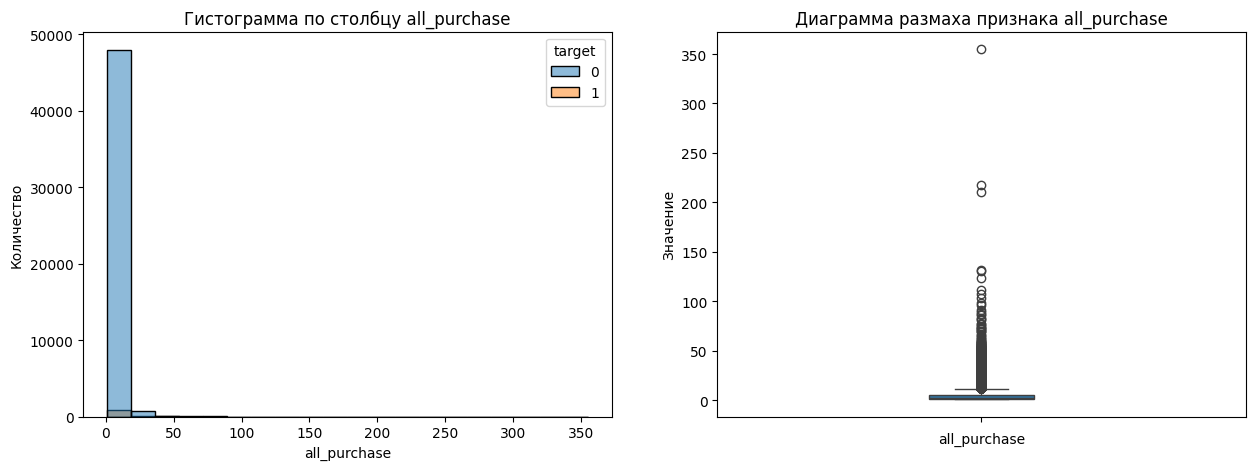

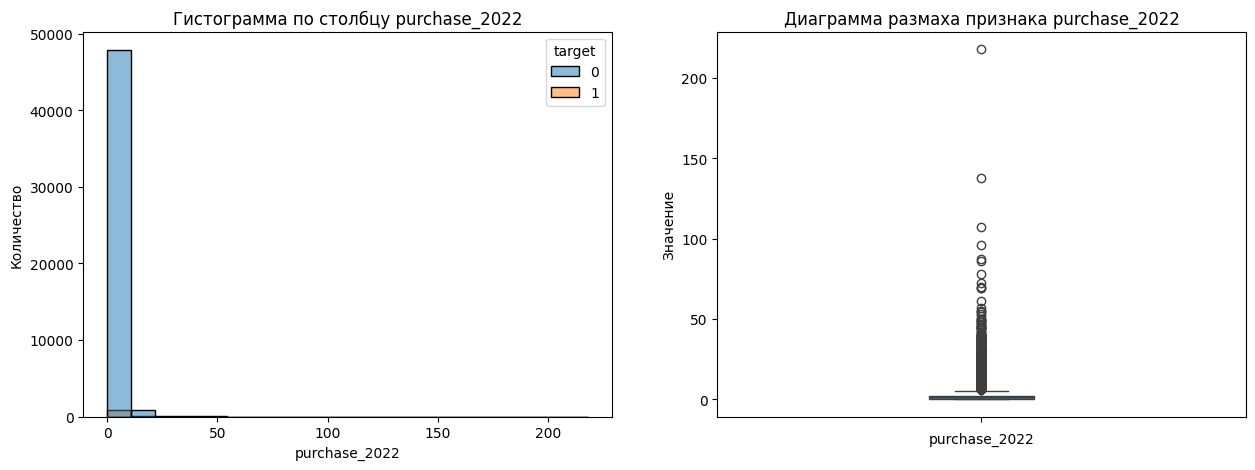

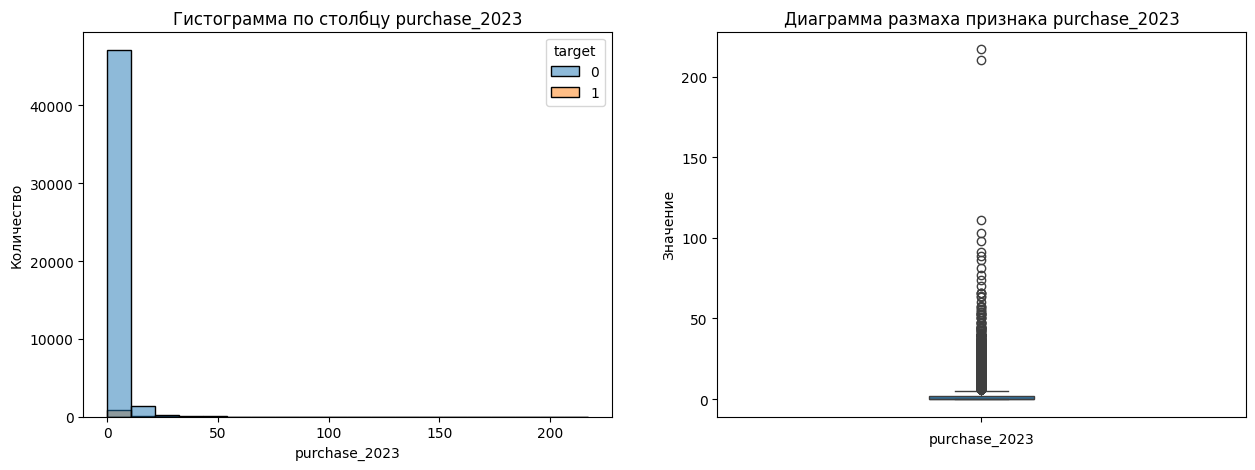

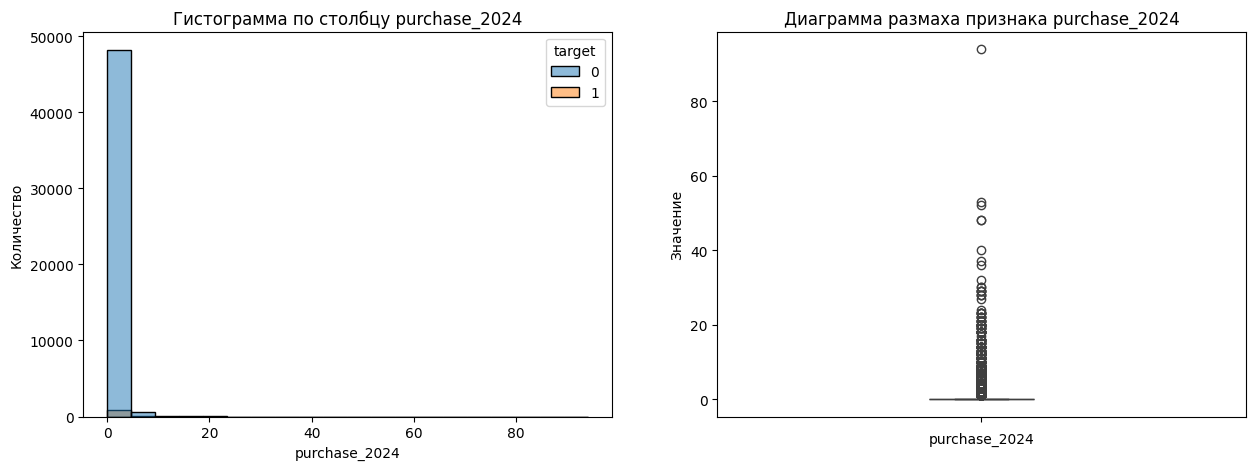

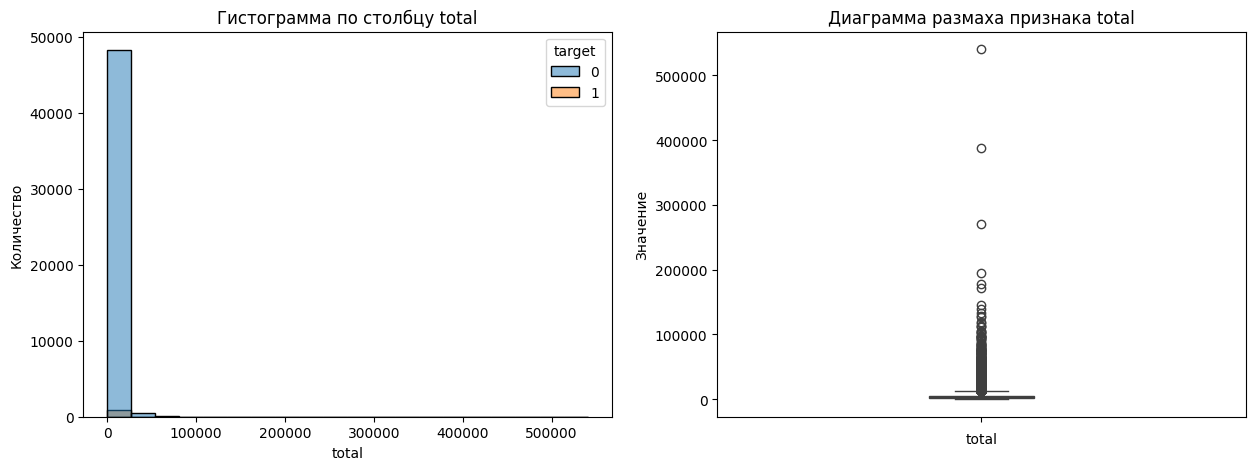

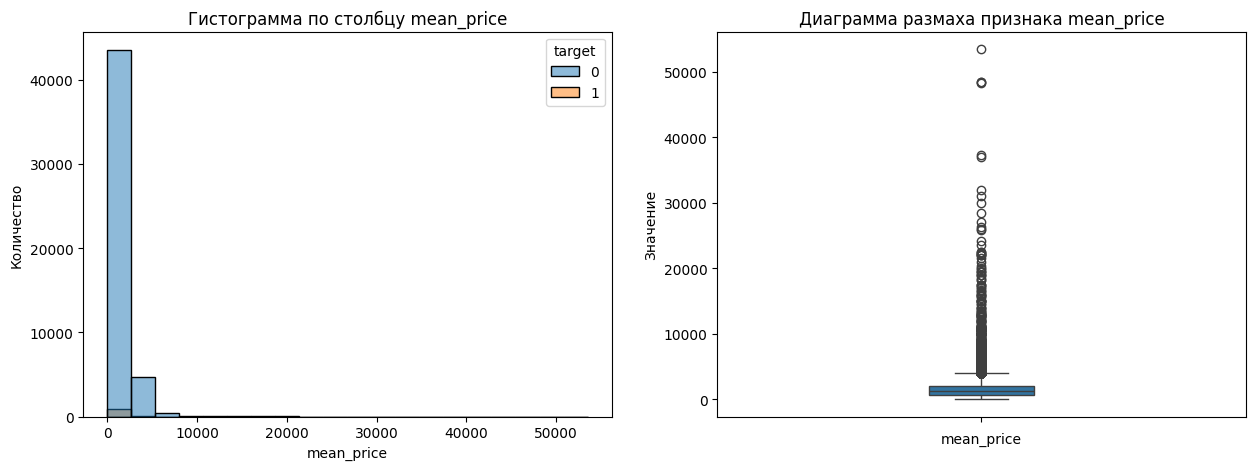

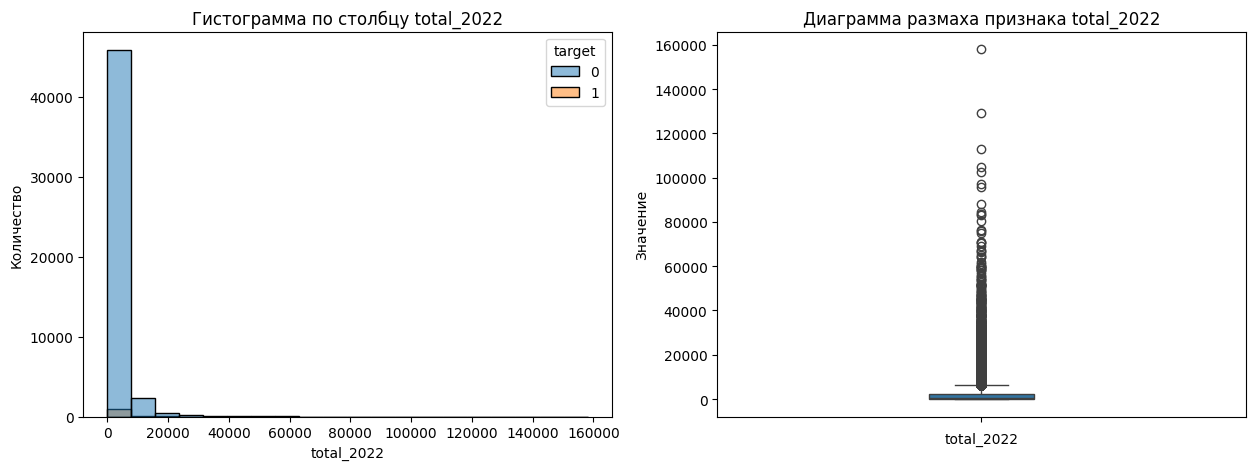

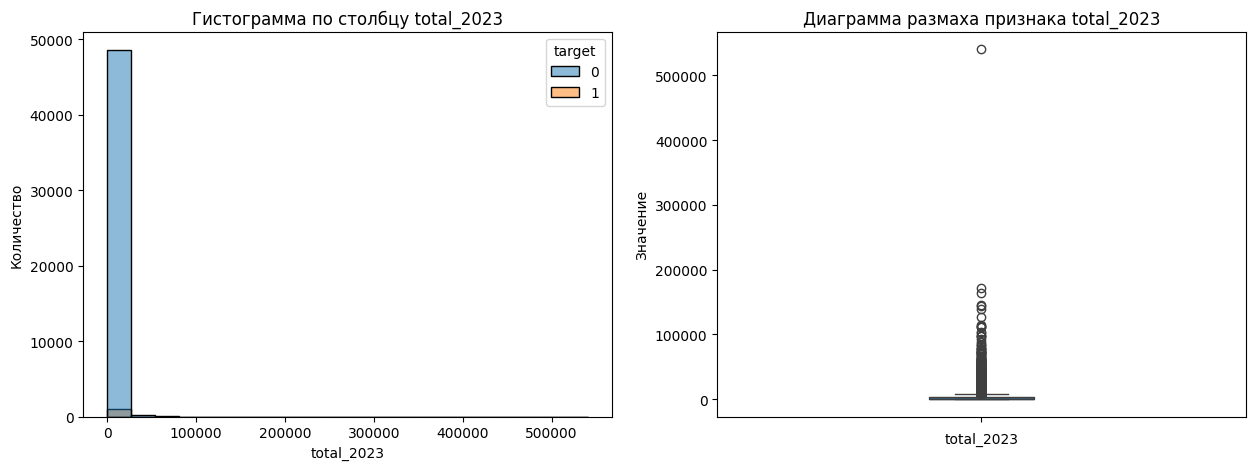

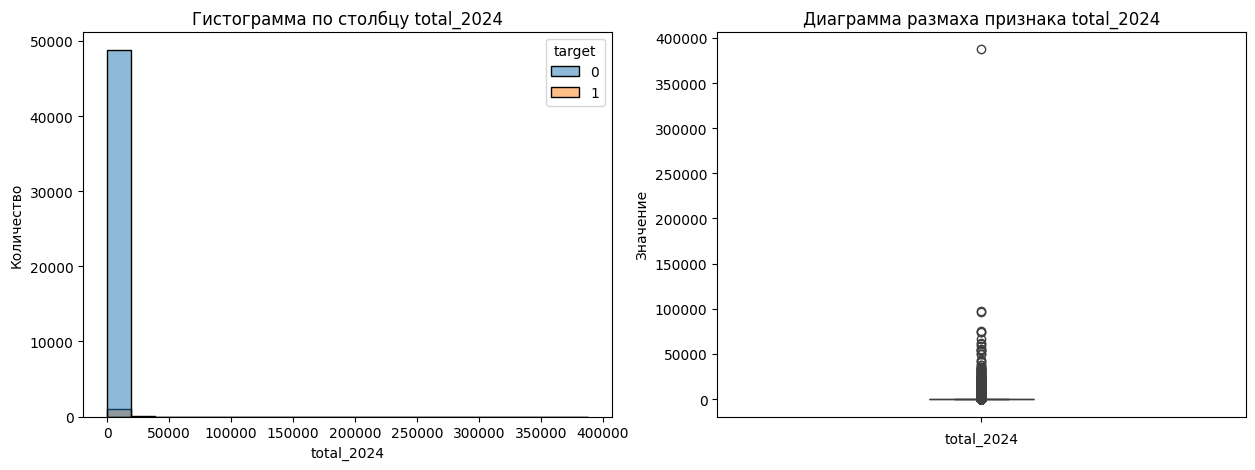

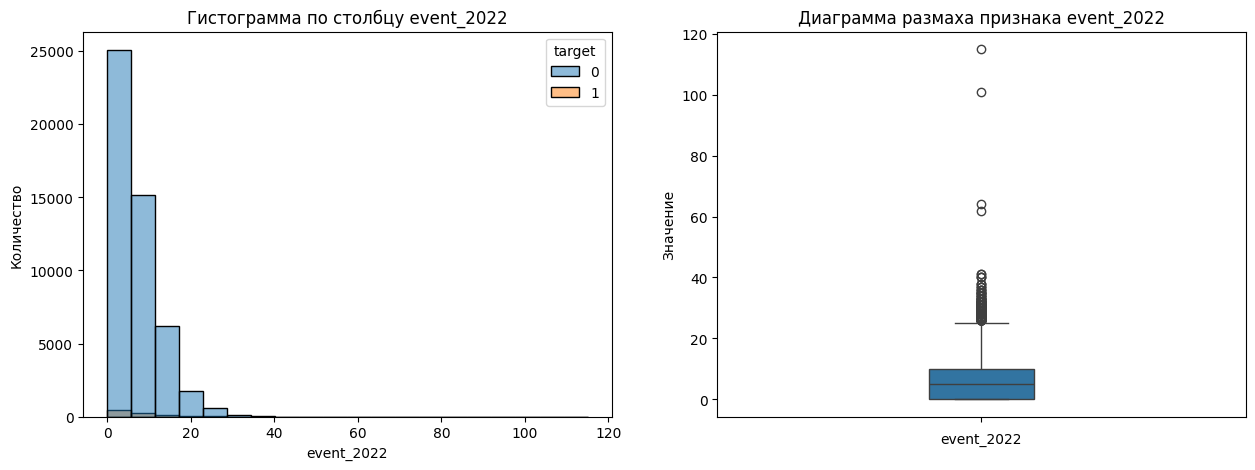

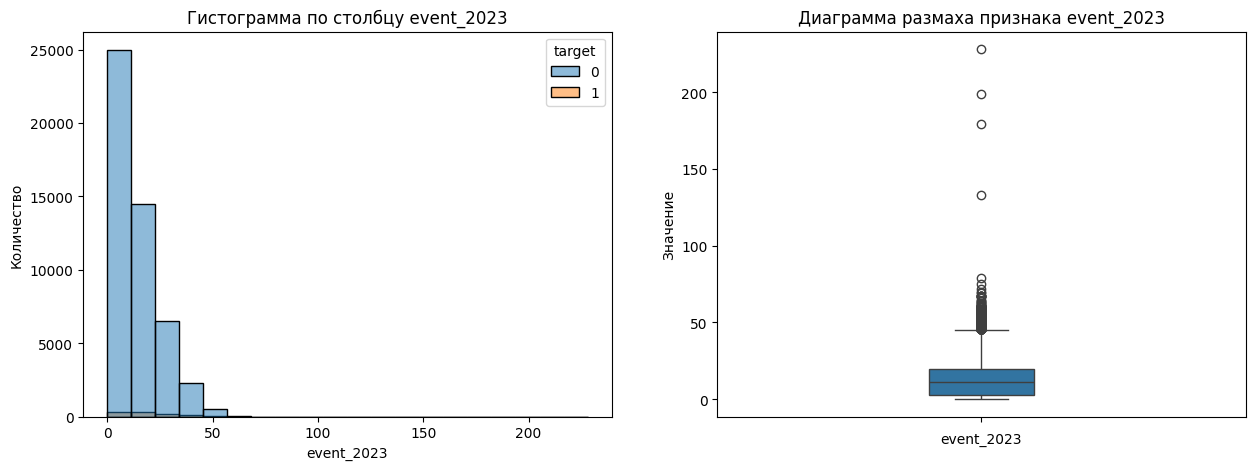

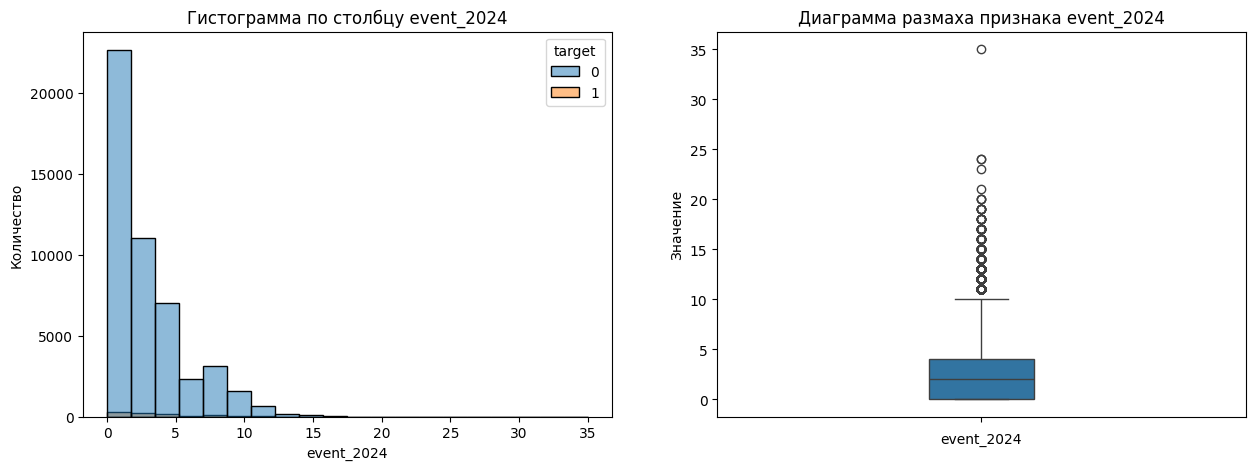

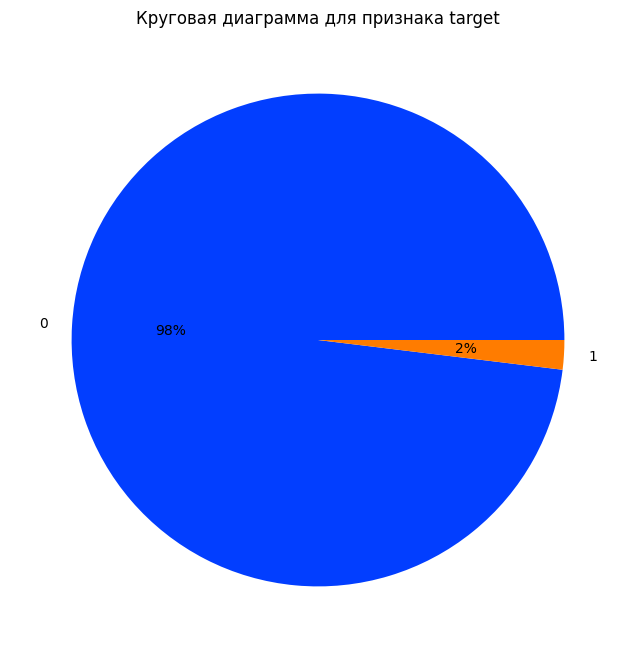

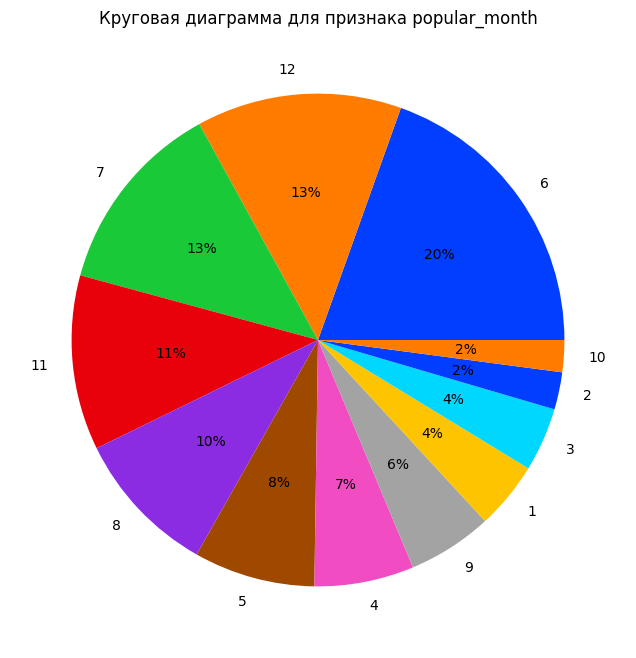

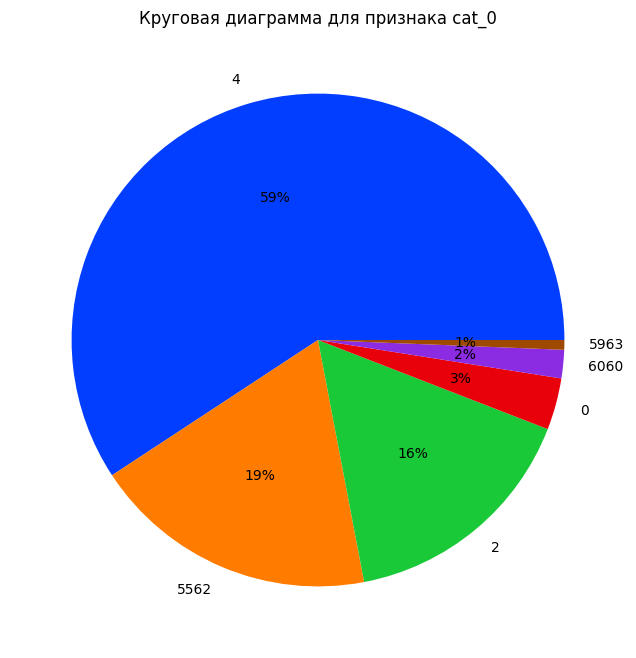

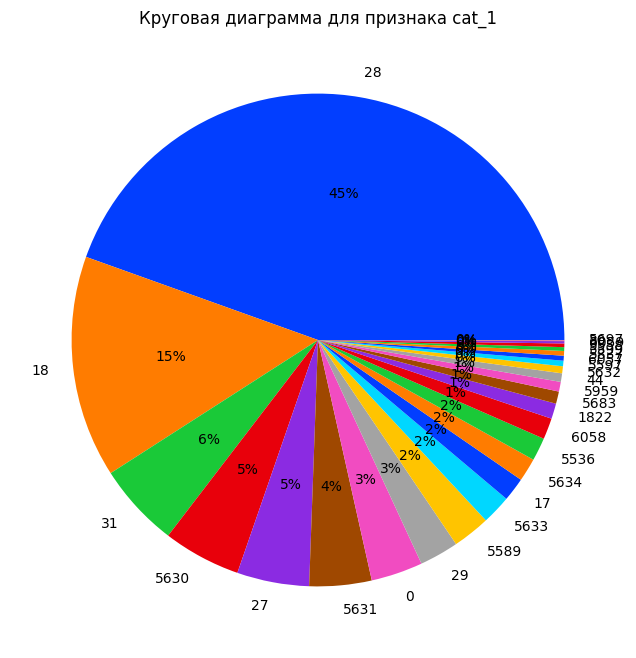

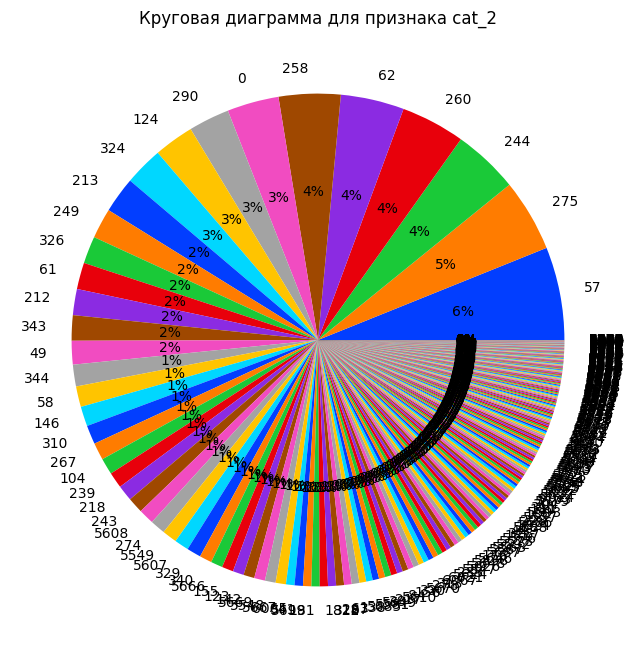

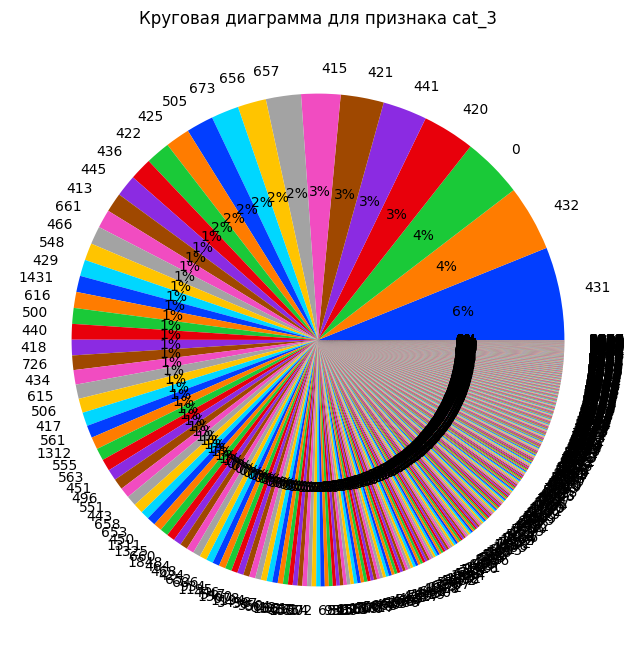

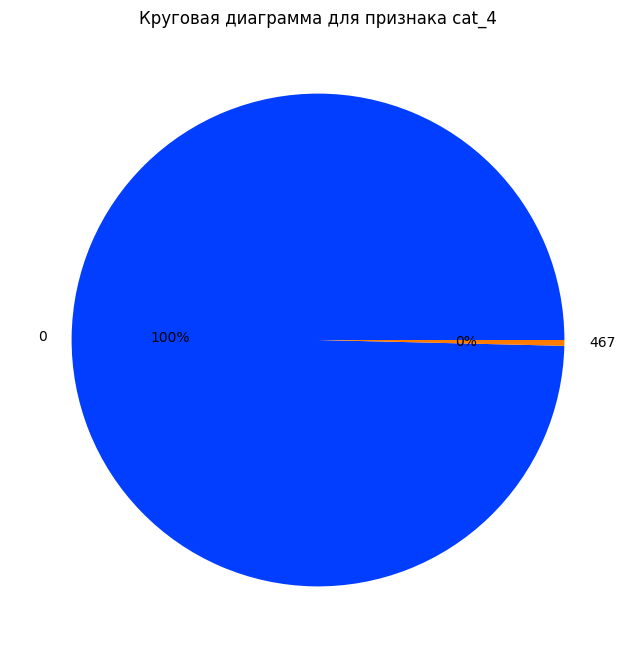

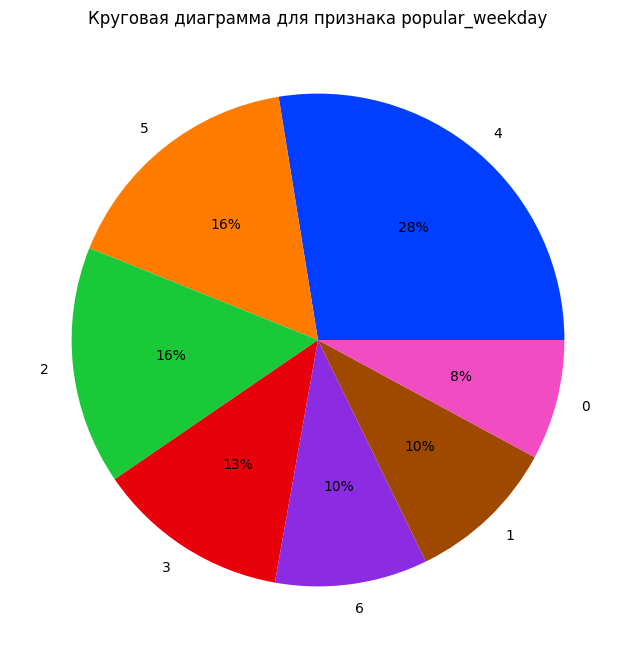

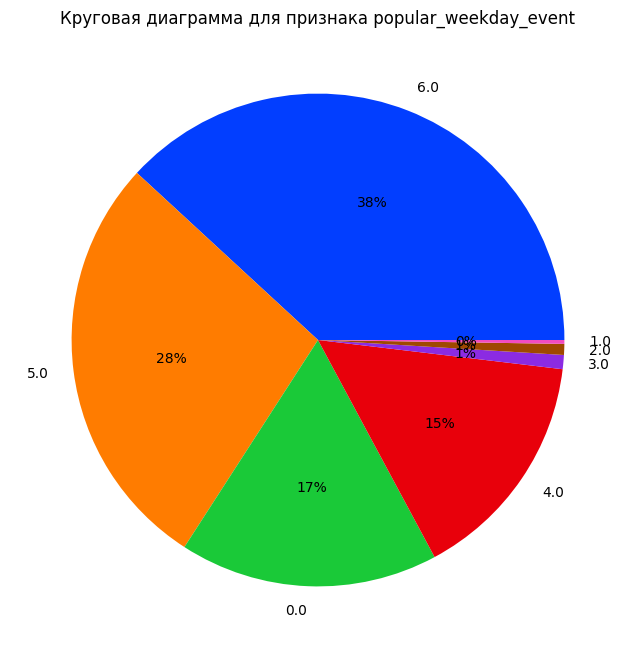

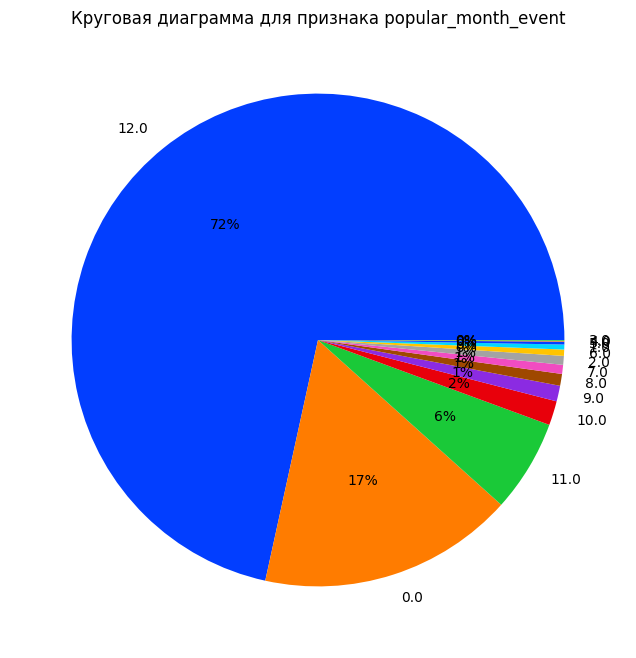

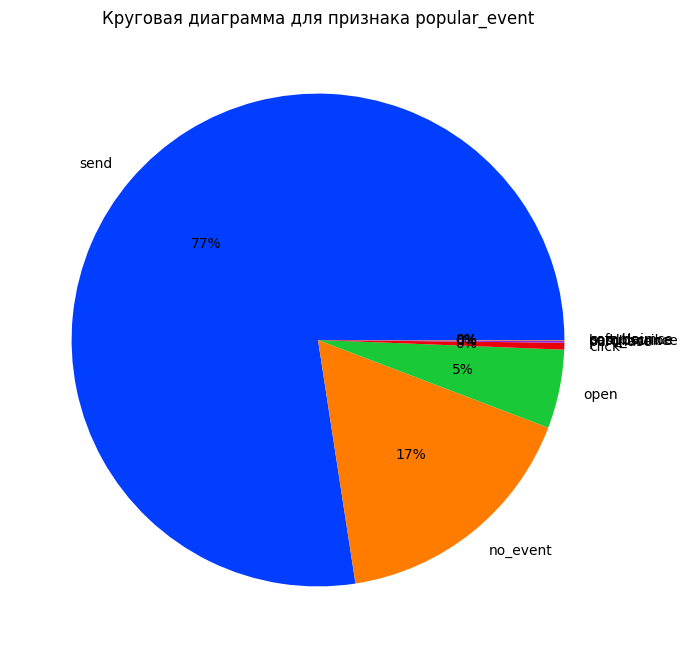

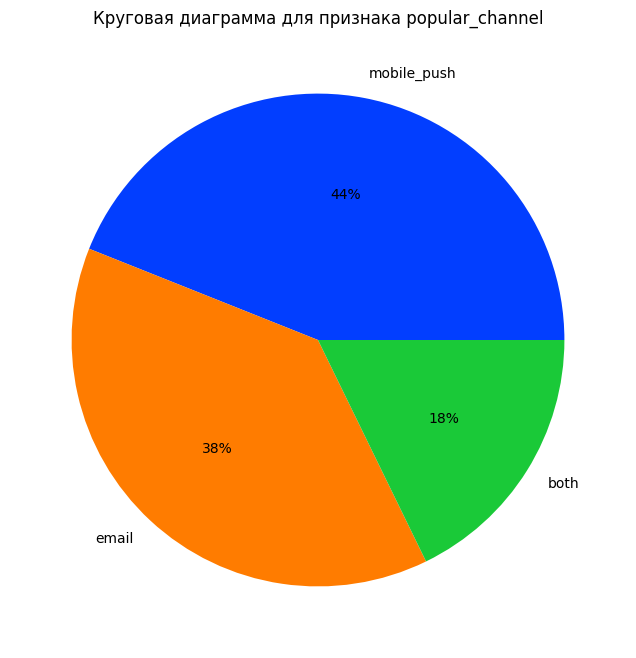

In [ ]:
lunge_analysis_all(df_target, analys_num_columns, analys_cat_columns, 'target') # Функция строит гистограммы, боксплоты и диаграммы с группировкой по столбцу target.

Что видно по данным:
1. Во многих столбцах есть аомально большие значения.
2. Для столбцов cat_2 и cat_3 очень много уникальных значений.
3. Клиентов категории 1 в данных всего 2 процента.

Удалим выпадающие значения по каждому столбцу.

In [ ]:
df_target = df_target.loc[df_target['all_purchase'] < 50]
df_target = df_target.loc[df_target['purchase_2022'] < 30]
df_target = df_target.loc[df_target['purchase_2023'] < 30]
df_target = df_target.loc[df_target['purchase_2024'] < 20]
df_target = df_target.loc[df_target['total'] < 100000]
df_target = df_target.loc[df_target['mean_price'] < 7000]
df_target = df_target.loc[df_target['total_2022'] < 20000]
df_target = df_target.loc[df_target['total_2023'] < 20000]
df_target = df_target.loc[df_target['total_2024'] < 20000]
df_target = df_target.loc[df_target['event_2022'] < 30]
df_target = df_target.loc[df_target['event_2023'] < 50]
df_target = df_target.loc[df_target['event_2024'] < 10]

In [ ]:
df_target = df_target.reset_index(drop=True)

Проверим сколько значений осталось. Изначально у нас было более 49 000 значений.

In [ ]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46374 entries, 0 to 46373
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              46374 non-null  int64  
 1   target                 46374 non-null  int64  
 2   purchase_2022          46374 non-null  float64
 3   purchase_2023          46374 non-null  float64
 4   purchase_2024          46374 non-null  float64
 5   all_purchase           46374 non-null  int64  
 6   popular_month          46374 non-null  int64  
 7   total                  46374 non-null  float64
 8   mean_price             46374 non-null  float64
 9   cat_0                  46374 non-null  int64  
 10  cat_1                  46374 non-null  int64  
 11  cat_2                  46374 non-null  int64  
 12  cat_3                  46374 non-null  int64  
 13  cat_4                  46374 non-null  int64  
 14  total_2022             46374 non-null  float64
 15  to

После удаления выпадов осталось 46 000 значений, что меньше 10% от всего числа данных.

Повторим анализ целевой таблицы.

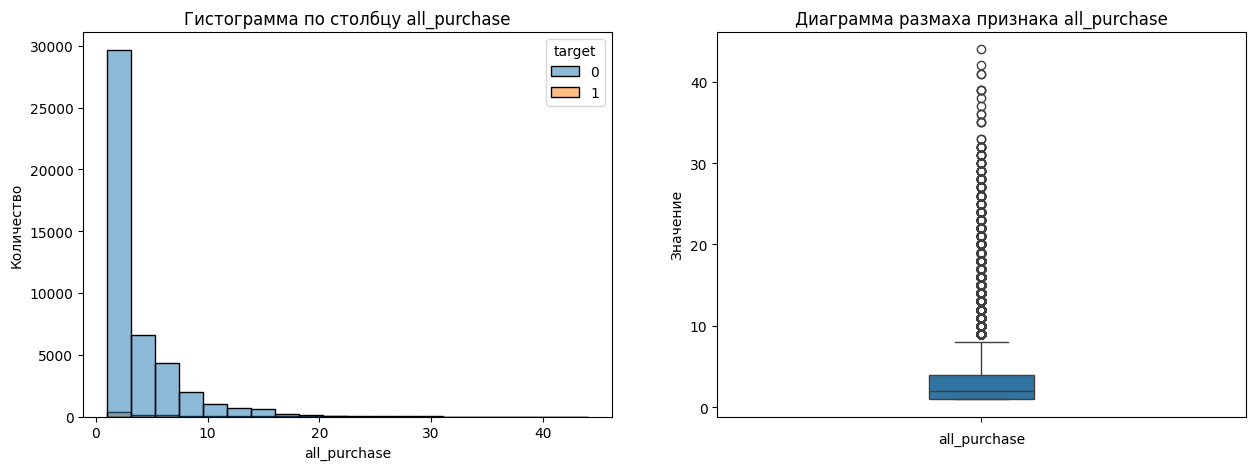

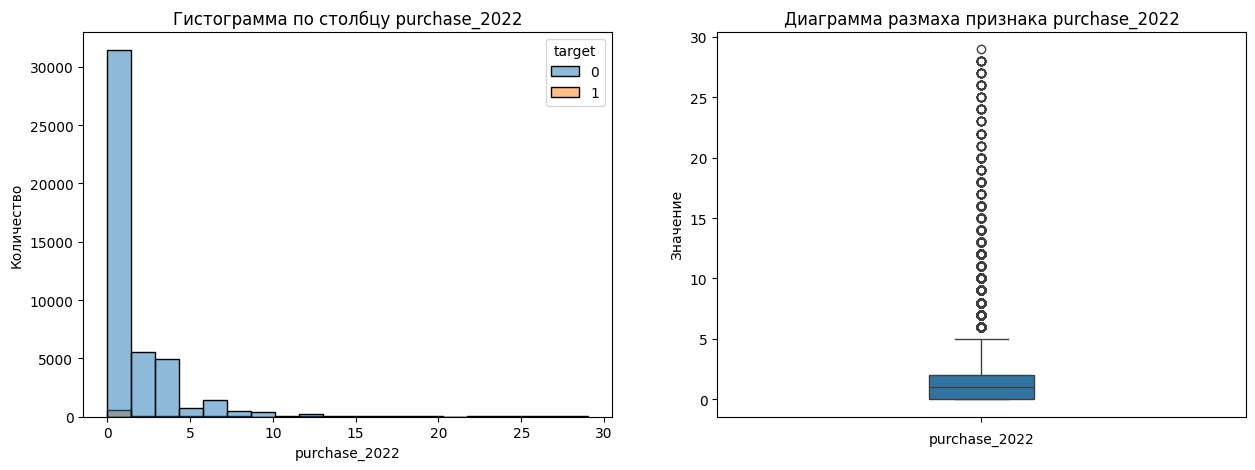

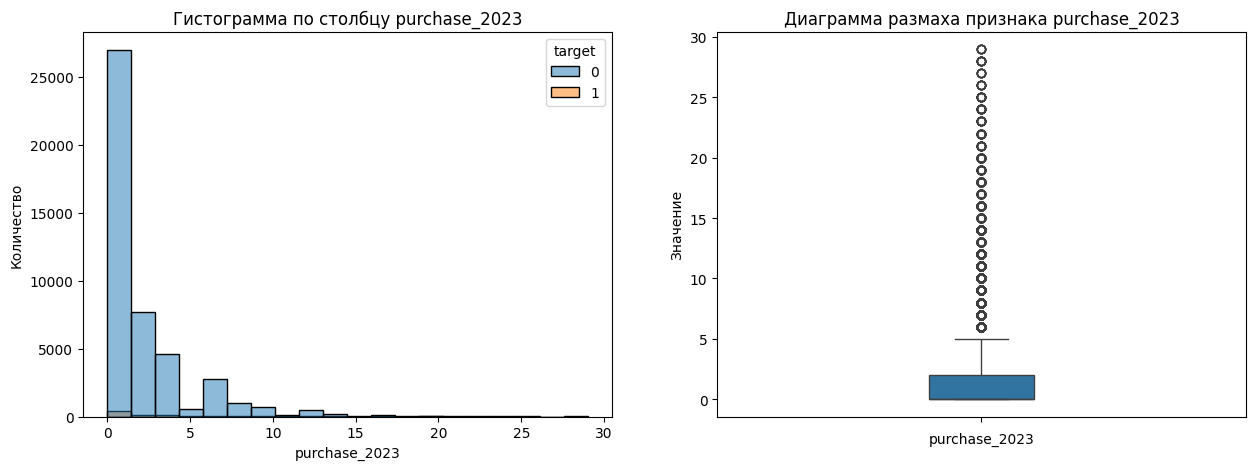

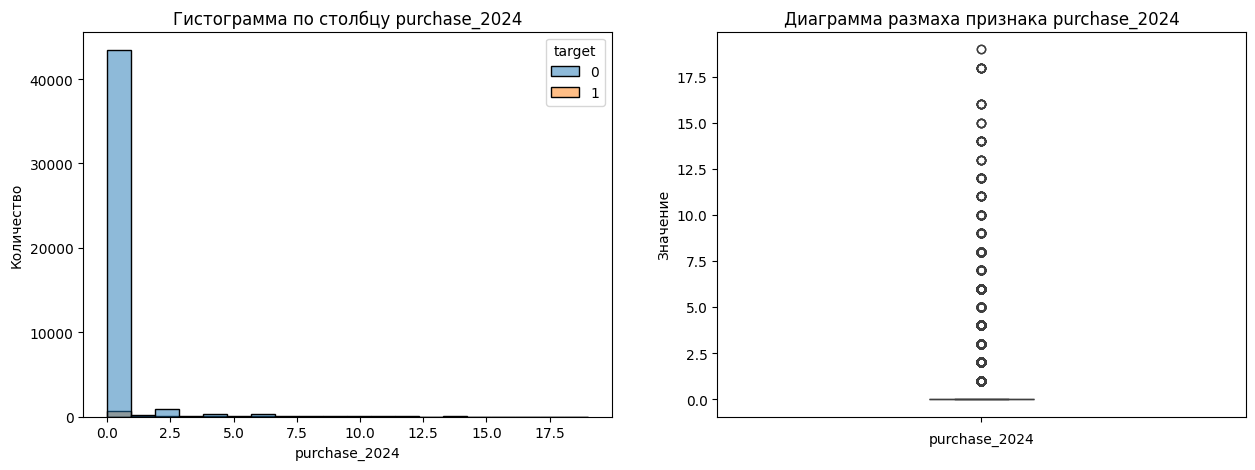

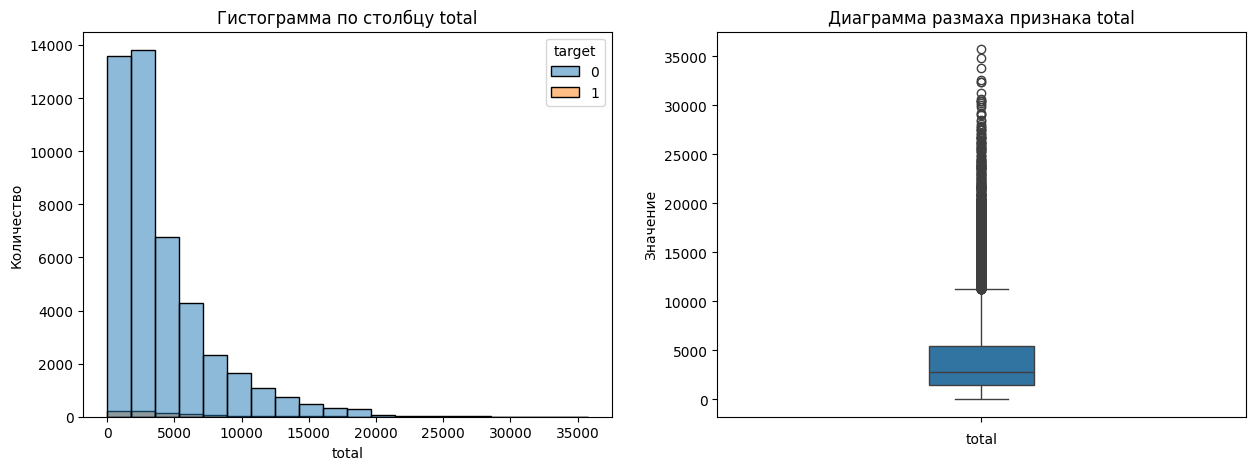

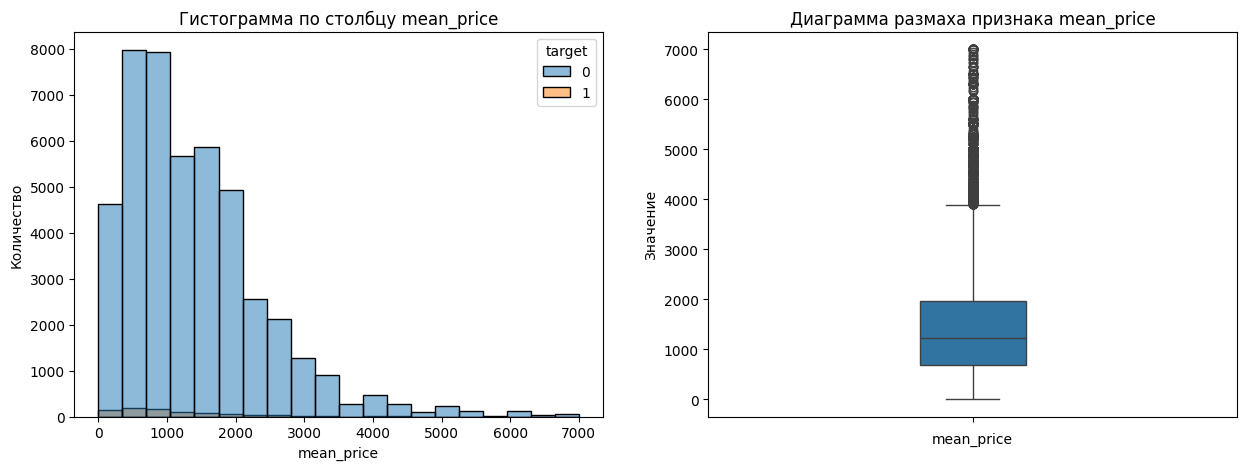

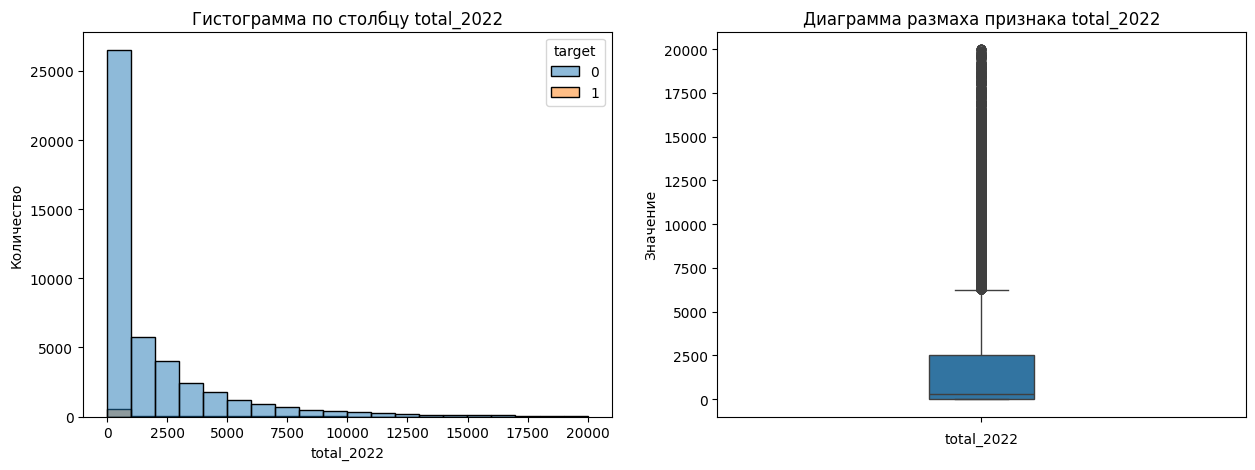

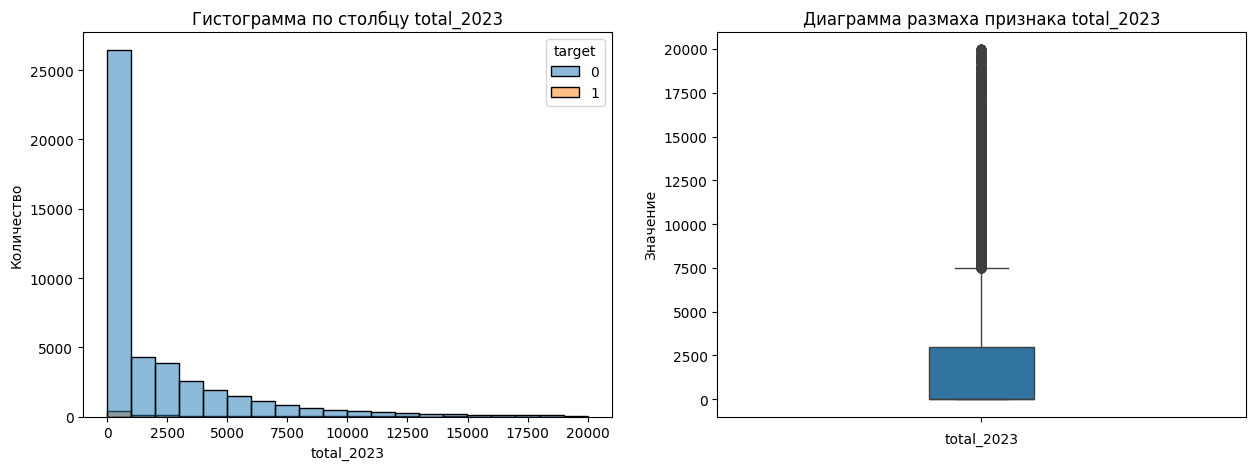

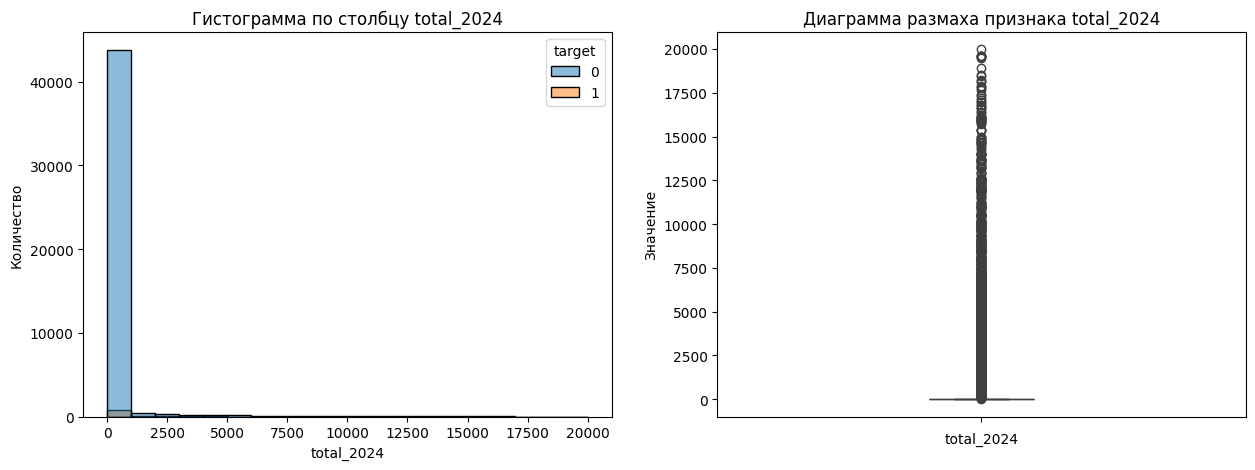

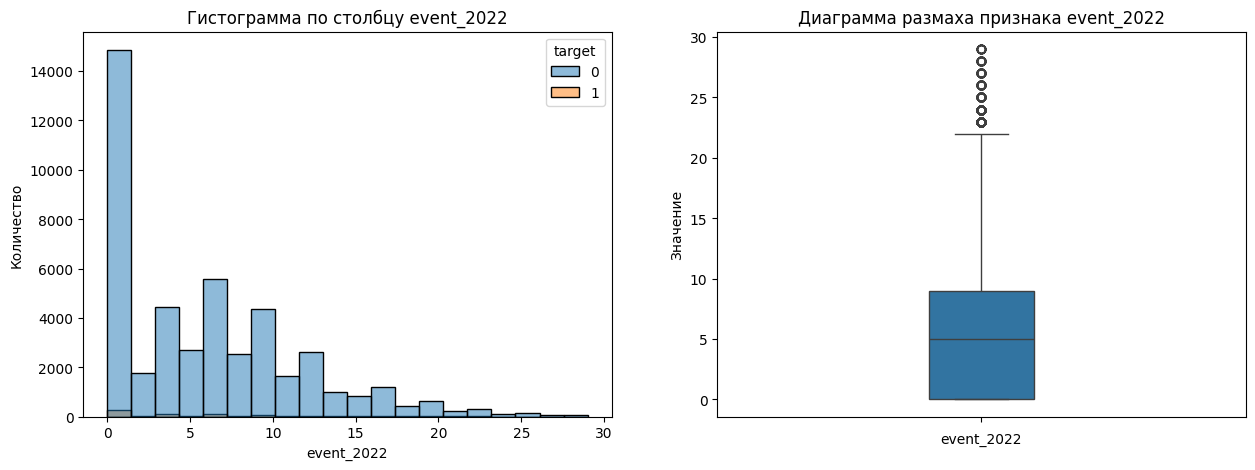

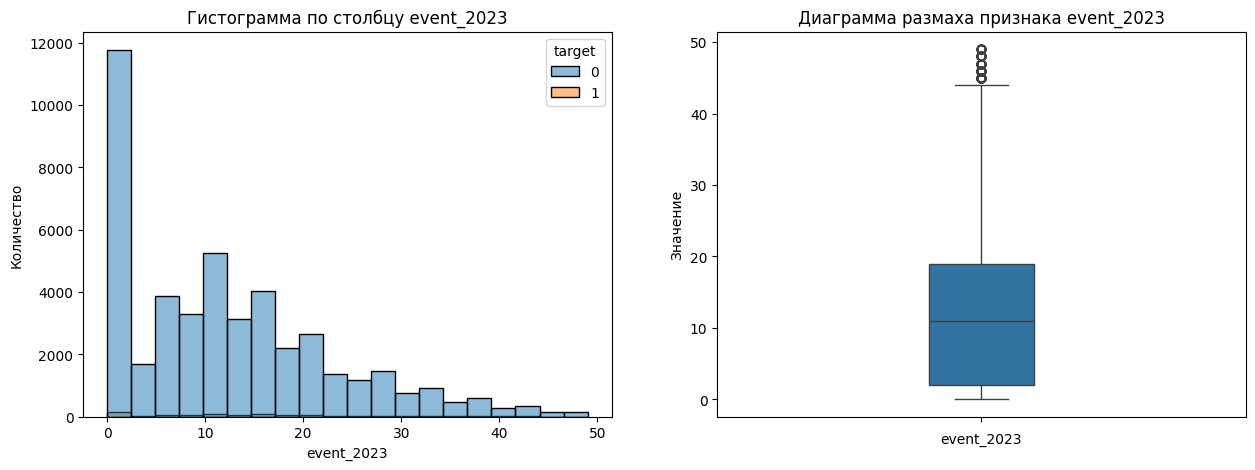

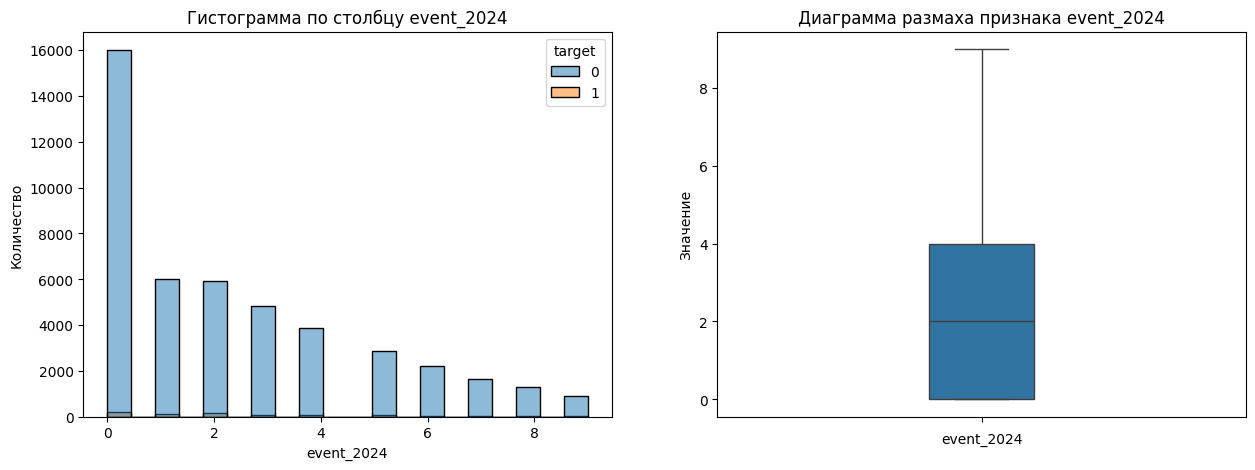

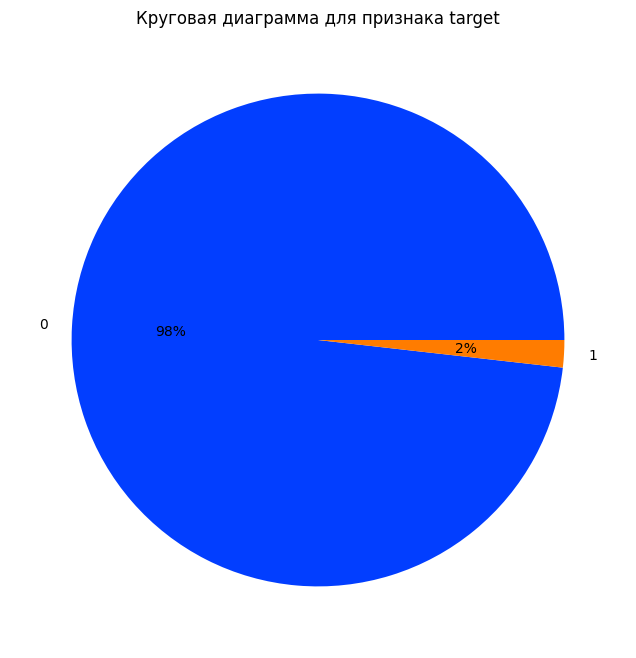

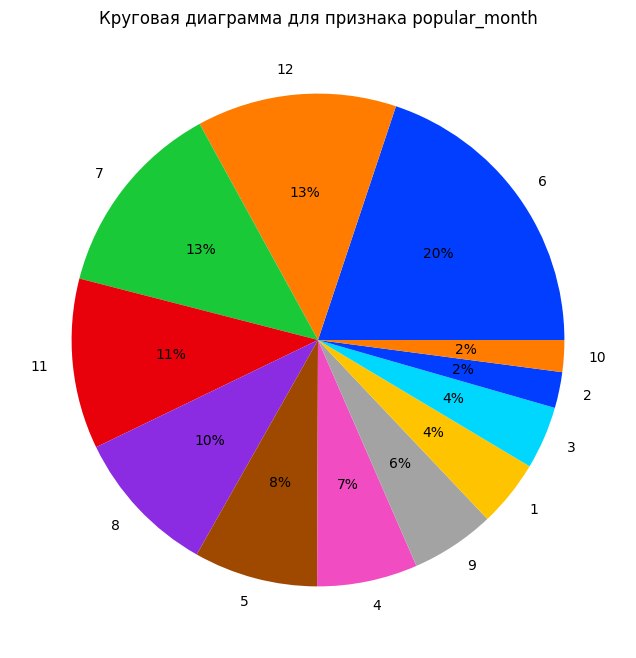

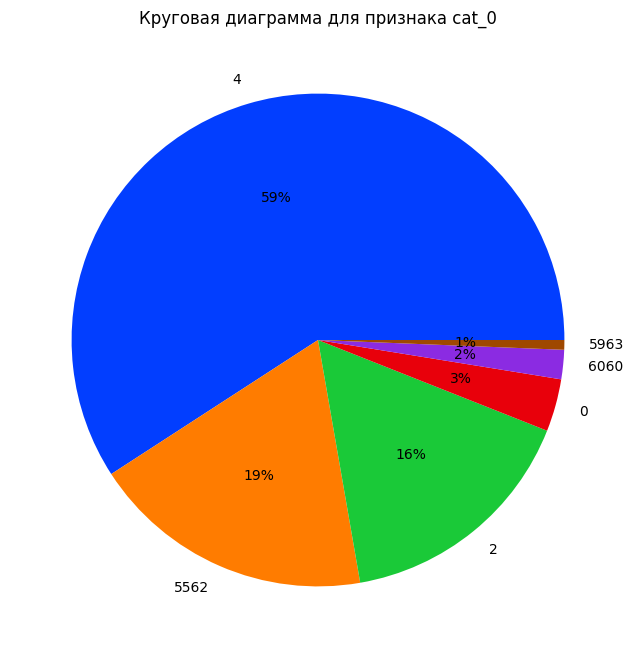

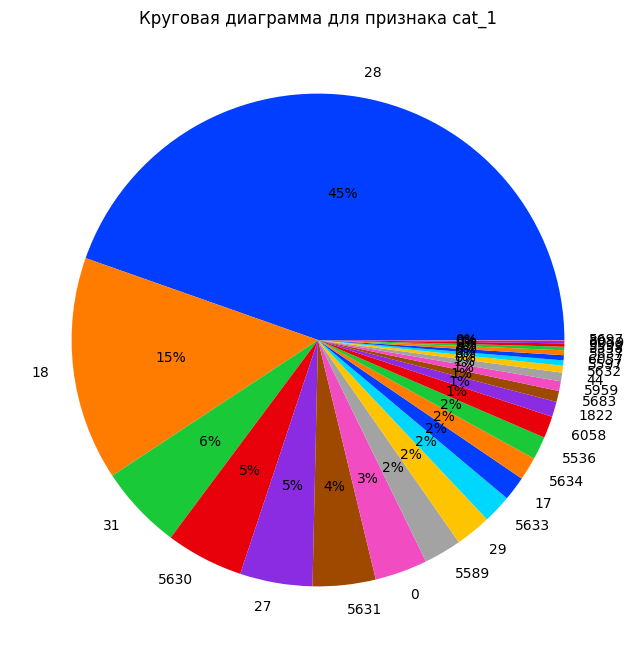

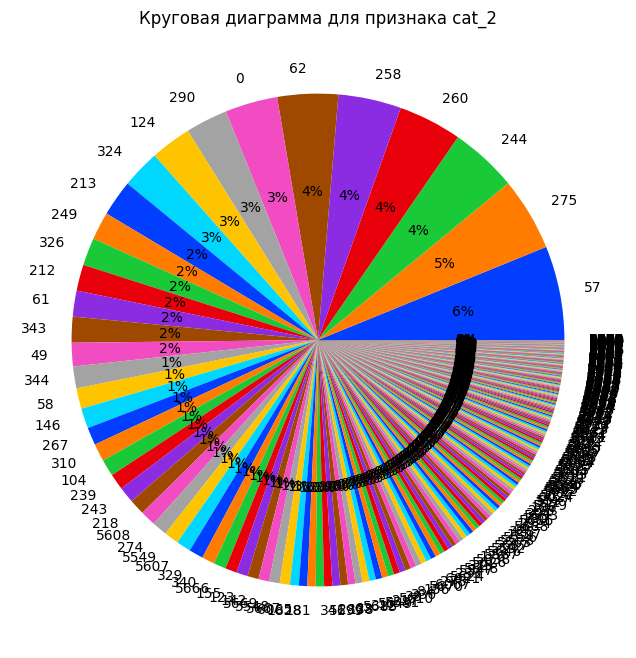

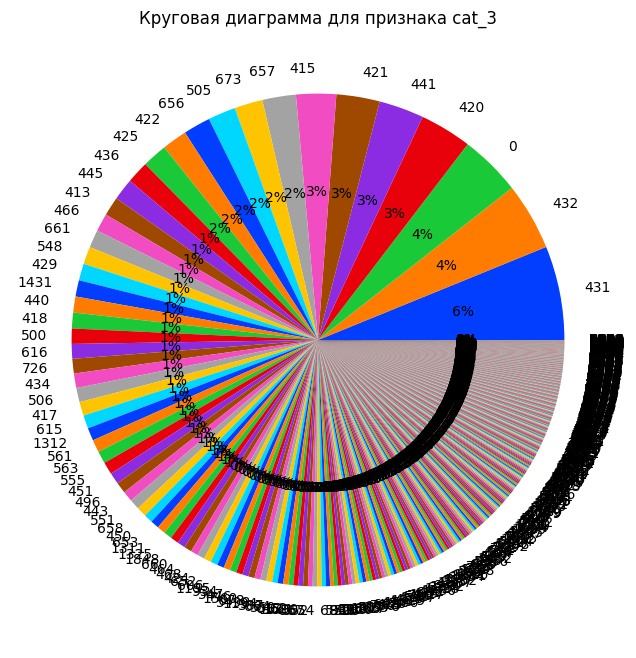

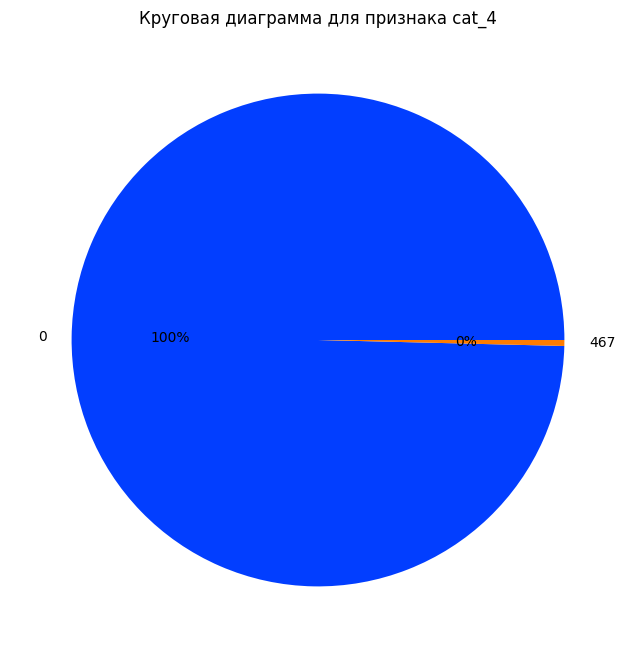

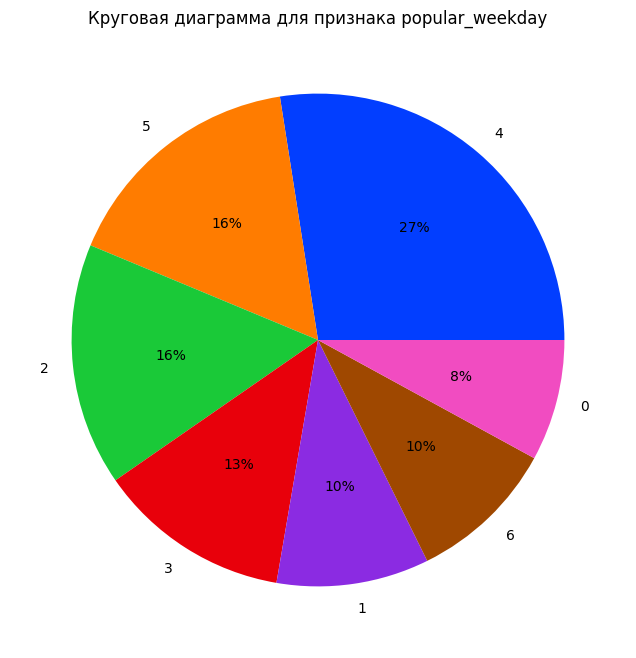

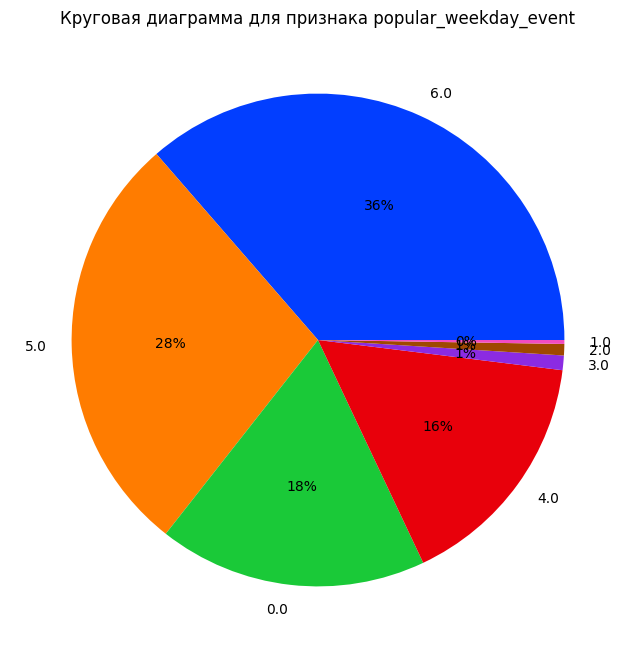

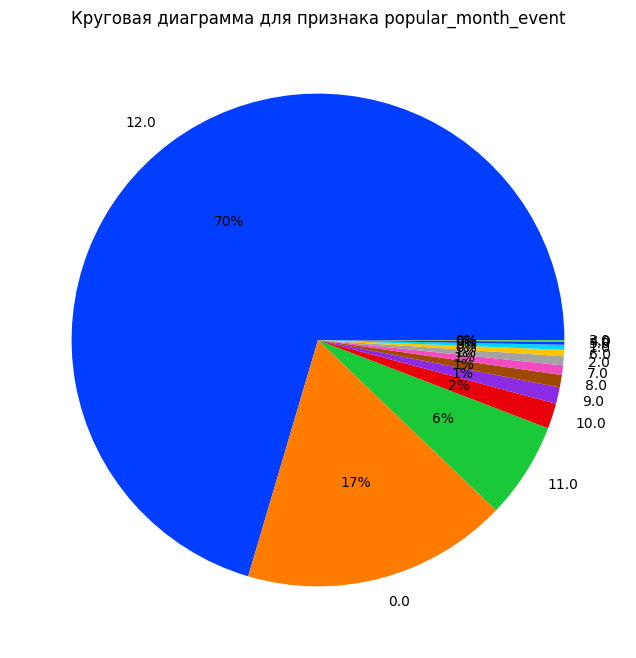

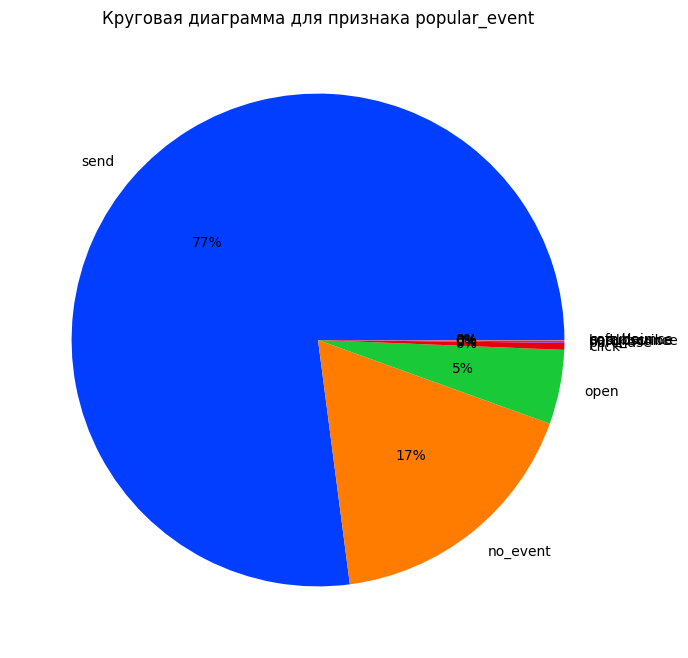

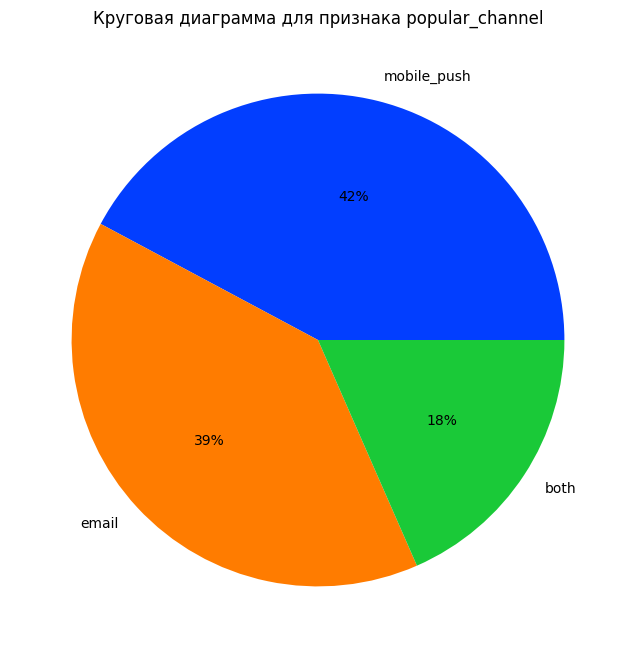

In [ ]:
lunge_analysis_all(df_target, analys_num_columns, analys_cat_columns, 'target')

Выпадов стало меньше, но они всё равно есть.

### Корреляционный анализ

Посчитаем корреляцию между признаками. Сперва создадим перечень столбцов для расчета.

In [ ]:
corr_columns = ['target', 'all_purchase', 'purchase_2022', 'purchase_2023',
       'purchase_2024', 'popular_month', 'total', 'mean_price', 'cat_0',
       'cat_1', 'cat_2', 'cat_3', 'cat_4', 'total_2022', 'total_2023',
       'total_2024', 'popular_weekday', 'popular_weekday_event',
       'popular_month_event', 'event_2022', 'event_2023', 'event_2024',
       'popular_event', 'popular_channel']

Посчитаем корреляцию методом Phik.

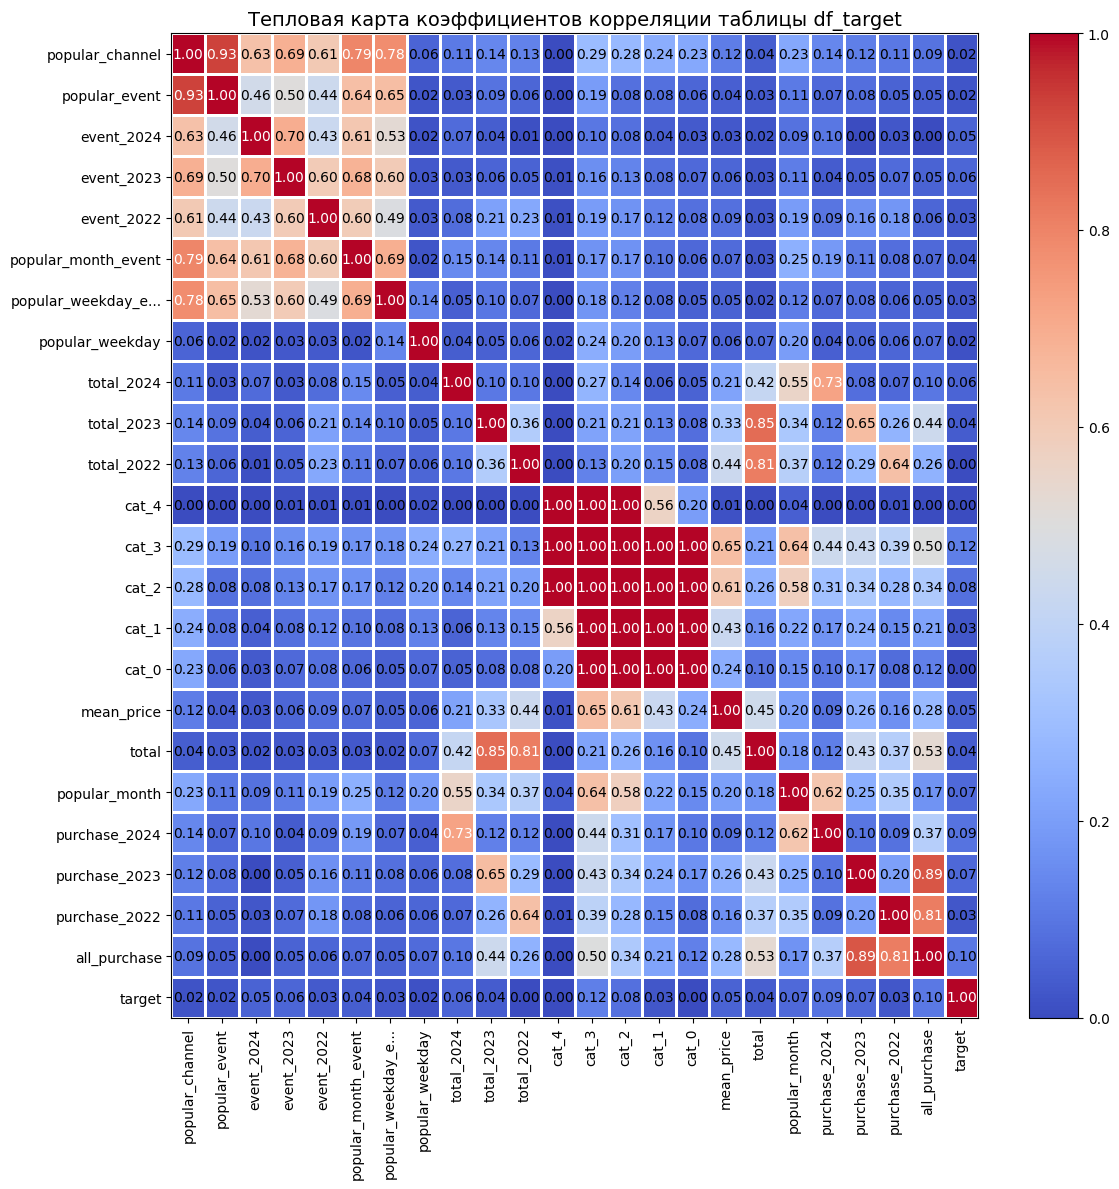

In [ ]:
phik_overview = df_target[corr_columns].phik_matrix(interval_cols=[
                                                                   'all_purchase',
                                                                   'purchase_2022',
                                                                   'purchase_2023',
                                                                   'purchase_2024',
                                                                   'popular_month',
                                                                   'total',
                                                                   'mean_price',
                                                                   'total_2022',
                                                                   'total_2023',
                                                                   'total_2024',
                                                                   'popular_weekday',
                                                                   'popular_weekday_event',
                                                                   'popular_month_event',
                                                                   'event_2022',
                                                                   'event_2023',
                                                                   'event_2024'
                                                                   ])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы df_target",
                        fontsize_factor=1,
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

Корреляция target ни с одним признаком не является очень высокой. При этом наблюдается мультиколлениарность у категорий.
Также высокая корреляция есть между покупками и коммуникациями с каналами, что вполне ожидаемо.

## Обучение моделей и выбор лучшей

Сперва разделим датафрейм df_target на две части в соотношении 75:25%. Одну часть сделаем для обучения и тестирования, вторую - для валидации. Предварительно выпишем перечень признаков.

In [ ]:
model_columns = ['target',
                 'all_purchase',
                 'purchase_2022',
                 'purchase_2023',
                 'purchase_2024',
                 'popular_month',
                 'total',
                 'mean_price',
                 'cat_0',
                 'cat_1',
                 'cat_2',
                 'cat_3',
                 'cat_4',
                 'total_2022',
                 'total_2023',
                 'total_2024',
                 'popular_weekday',
                 'popular_weekday_event',
                 'popular_month_event',
                 'event_2022',
                 'event_2023',
                 'event_2024',
                 'popular_event',
                 'popular_channel']

In [ ]:
df_target_train = df_target.loc[:37387, model_columns] # 80 % датафрейма

In [ ]:
df_target_valid = df_target.loc[37387:, model_columns] # 20 % датафрейма

Проверим как разделилось.

In [ ]:
df_target_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37388 entries, 0 to 37387
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 37388 non-null  int64  
 1   all_purchase           37388 non-null  int64  
 2   purchase_2022          37388 non-null  float64
 3   purchase_2023          37388 non-null  float64
 4   purchase_2024          37388 non-null  float64
 5   popular_month          37388 non-null  int64  
 6   total                  37388 non-null  float64
 7   mean_price             37388 non-null  float64
 8   cat_0                  37388 non-null  int64  
 9   cat_1                  37388 non-null  int64  
 10  cat_2                  37388 non-null  int64  
 11  cat_3                  37388 non-null  int64  
 12  cat_4                  37388 non-null  int64  
 13  total_2022             37388 non-null  float64
 14  total_2023             37388 non-null  float64
 15  to

In [ ]:
df_target_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8987 entries, 37387 to 46373
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 8987 non-null   int64  
 1   all_purchase           8987 non-null   int64  
 2   purchase_2022          8987 non-null   float64
 3   purchase_2023          8987 non-null   float64
 4   purchase_2024          8987 non-null   float64
 5   popular_month          8987 non-null   int64  
 6   total                  8987 non-null   float64
 7   mean_price             8987 non-null   float64
 8   cat_0                  8987 non-null   int64  
 9   cat_1                  8987 non-null   int64  
 10  cat_2                  8987 non-null   int64  
 11  cat_3                  8987 non-null   int64  
 12  cat_4                  8987 non-null   int64  
 13  total_2022             8987 non-null   float64
 14  total_2023             8987 non-null   float64
 15 

Разделилось корректно.

Начнем формировать пайплайн.

In [ ]:
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_target_train.drop('target', axis=1),
    df_target_train['target'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    #stratify = df_target_train['target']
    )

X_train.shape, X_test.shape

((28041, 23), (9347, 23))

In [ ]:
# сформируем списки с названиями признаков
ohe_columns = ['popular_channel',
               'popular_event',
               'cat_4',
               'popular_weekday',
               'popular_weekday_event',
               'popular_month_event'
               ]

num_columns = [
    'all_purchase',
    'purchase_2022',
    'purchase_2023',
    'purchase_2024',
    'popular_month',
    'total',
    'mean_price',
    'total_2022',
    'total_2023',
    'total_2024',
    'event_2022',
    'event_2023',
    'event_2024',
    'cat_0',
    'cat_1',
    'cat_2',
    'cat_3'
    ]

# сформируем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
    ]
    )

# сформируем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LGBMClassifier()
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__num_leaves': [100],
        'models__n_estimators' : [200],
        'models__objective':['binary'],
        'models__class_weight':['balanced'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ['lbfgs',
                           'liblinear',
                           'newton-cg'
                          ],
        'models__penalty':['l2'],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]


Pipeline готов. Запустим перебор моделей для поиска лучшей.

In [ ]:
%%time

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid_search.best_score_)


# проверим работу модели на тестовой выборке
preds = grid_search.predict_proba(X_test)

print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, preds[:, 1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_channel',
                                                   'popular_event', 'cat_4',
                                                   'popular_weekday',
                   

На тестовой выборке получилось 0,701, хотя на кросс-валидационной 0,66.

### Контроль качества модели
Проверим теперь на валидационной выборке. Сперва выгрузим модель и подготовку данных из пайплайна.

In [ ]:
model = grid_search.best_estimator_.named_steps['models']

In [ ]:
preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

Получим названия признаков

In [ ]:
encoder = ohe_pipe['ohe']

encoder.fit(X_train[ohe_columns].dropna())

cat_encoder = encoder.get_feature_names_out()

num_features = ['all_purchase',
    'purchase_2022',
    'purchase_2023',
    'purchase_2024',
    'popular_month',
    'total',
    'mean_price',
    'total_2022',
    'total_2023',
    'total_2024',
    'event_2022',
    'event_2023',
    'event_2024',
    'cat_0',
    'cat_1',
    'cat_2',
    'cat_3'
    ]

feature_names = np.concatenate([cat_encoder, num_features])
feature_names

array(['popular_channel_both', 'popular_channel_email',
       'popular_channel_mobile_push', 'popular_event_click',
       'popular_event_complain', 'popular_event_hard_bounce',
       'popular_event_no_event', 'popular_event_open',
       'popular_event_purchase', 'popular_event_send',
       'popular_event_soft_bounce', 'popular_event_unsubscribe',
       'cat_4_467', 'popular_weekday_0', 'popular_weekday_1',
       'popular_weekday_2', 'popular_weekday_3', 'popular_weekday_4',
       'popular_weekday_5', 'popular_weekday_6',
       'popular_weekday_event_0.0', 'popular_weekday_event_1.0',
       'popular_weekday_event_2.0', 'popular_weekday_event_3.0',
       'popular_weekday_event_4.0', 'popular_weekday_event_5.0',
       'popular_weekday_event_6.0', 'popular_month_event_0.0',
       'popular_month_event_1.0', 'popular_month_event_2.0',
       'popular_month_event_3.0', 'popular_month_event_4.0',
       'popular_month_event_5.0', 'popular_month_event_6.0',
       'popular_month_ev

Подготовим данные с помощью метода, выгруженного из Pipeline

In [ ]:
X_valid_preprocessed = preprocessor.transform(df_target_valid.drop('target', axis=1))

In [ ]:
preds_valid = model.predict_proba(X_valid_preprocessed)

Посчитаем метрику ROC-AUC на валидационных данных.

In [ ]:
roc_auc_score(df_target_valid['target'], preds_valid[:, 1])

0.7042949024857722

На валидационных данных значение ROC-AUC тоже получилось выше 0.7.

## Анализ работы модели

Теперь проанализируем работу модели. Сделаем выборку для SHAP.

In [ ]:
shap_sample = shap.sample(X_valid_preprocessed, 1)

In [ ]:
explainer = shap.KernelExplainer(model.predict, shap_sample)
shap_values = explainer(X_valid_preprocessed)

  0%|          | 0/8987 [00:00<?, ?it/s]

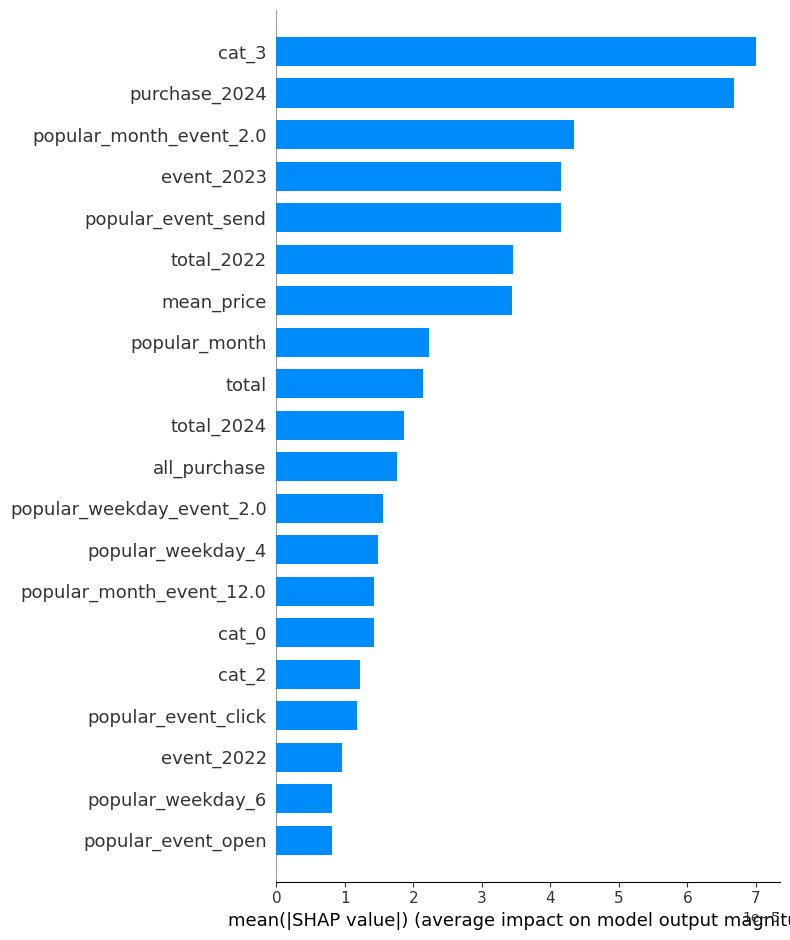

In [ ]:
shap.summary_plot(shap_values, X_valid_preprocessed, plot_type="bar", feature_names=feature_names)

На выводы модели наибольшее влияние имеет количество заказов в 2024 году, третья категория в перечне категорий, количество ивентов в 2023 году.

## Выводы
В работе выполнено следующее:
1. Создано около 23 признаков для передачи в модель.
2. Проведен исследовательский и корреляционный анализ данных.
3. Сформирован Pipeline и выбрана наилучшая модель.
4. Проверена работа модели на данных, которые ранее ей не были показаны.
5. Проведен анализ работы модели, установлен вклад каждого признака в модель.

Результаты работы:
1. Наилучшая модель оказалась LogisticRegression с методом подготовки данных
2. Достигнуто значение метрики ROC-AUC 0,701 на тренировочных данных и 0,704 на валидационных.
3. Наибольший вклад в работу модели вносит количество заказов в 2024 году.

Предложения по улучшению прогноза:
1. Предоставить дополнительные признаки по клиентам, к примеру, пол, возраст.
2. Оптимизировать сбор информации по категориям товаров.